# 0.0 IMPORT

In [1]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
import matplotlib.image      as mpimg

from IPython.core.display    import HTML
from IPython.display         import Image
from tabulate                import tabulate
#from mpl_toolkits.basemap    import Basemap
from scipy.stats             import chi2_contingency

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.ensemble        import RandomForestRegressor
import xgboost               as xgb

from sklearn.metrics         import mean_absolute_error, mean_squared_error

## 0.1 Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat ) / y ) )

def cross_validation( X_training, kfold, model_name, model, verbose=False ):
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        
        # filtering dataset
        training = X_training
        validation = X_training

        # training and validation dataset
        # training
        xtraining = training.drop( ['price' ], axis=1 )
        ytraining = training['price']

        #validation
        xvalidation = validation.drop( ['price'], axis=1 )
        yvalidation = validation['price']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('data/vehicles.csv', low_memory=False, error_bad_lines=False)

In [5]:
df_raw.sample()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
288013,7120467372,https://syracuse.craigslist.org/cto/d/pennellv...,syracuse,https://syracuse.craigslist.org,9000,2015.0,ford,fiesta se hatchback,excellent,NaN,gas,58562.0,lien,automatic,NaN,fwd,NaN,hatchback,blue,https://images.craigslist.org/00N0N_gpEmNWJ5w1...,"2015 Ford Fiesta for sale, excellent condition...",NaN,ny,43.2609,-76.2395


# 1.0 STEP 01 - DESCRIPTION OF DATA

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns

# The columns already have a label that I want and easy to understand.

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 435849
Number of Cols: 25


## 1.3 Data Types

In [9]:
df1.dtypes
# At first, the types of the variables are corrected.

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
vin              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
dtype: object

## 1.4 Check Response Variable

<AxesSubplot:xlabel='price'>

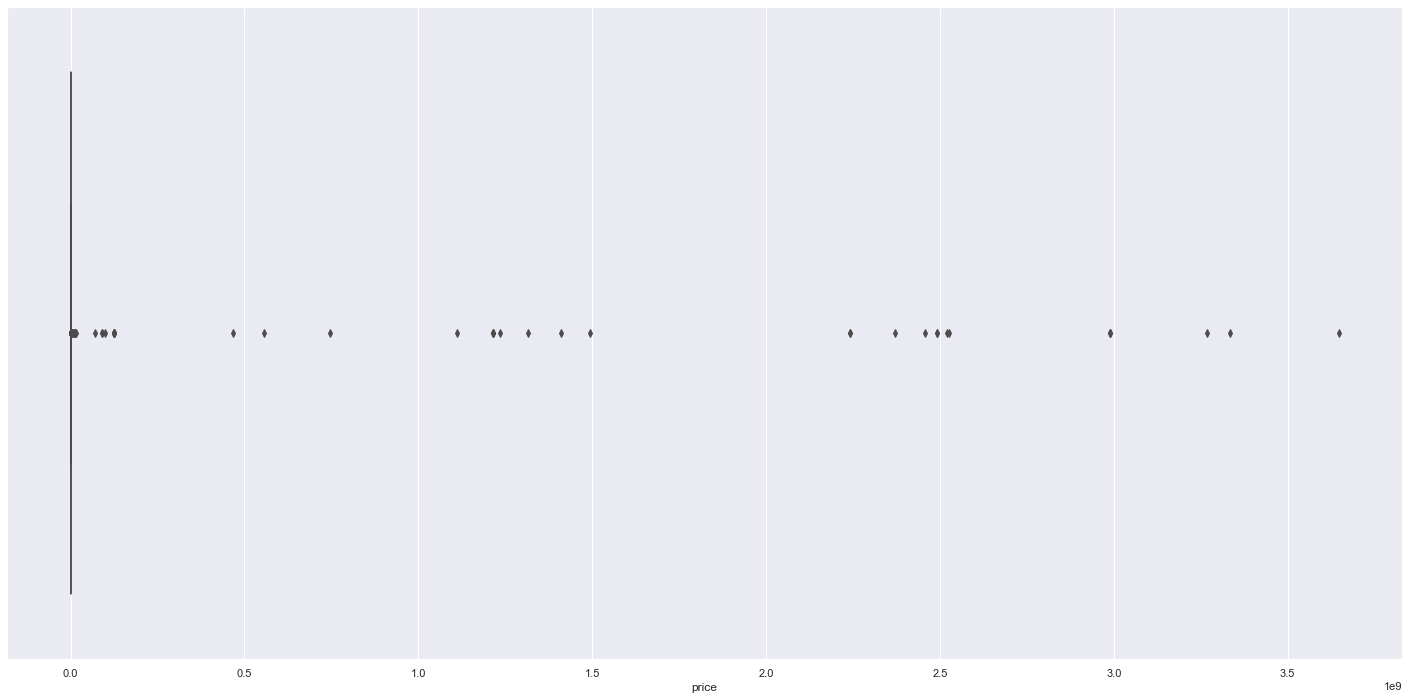

In [10]:
sns.boxplot( df1['price'] )

# We can see that the values within the response variable are quite different.
# As these values are extremely out of "normal", we will resolve this before continuing our project.

In [11]:
# As I want to treat outliers only at the right time, I will only define a value range that I think is acceptable as a used car sales price.

df1 = df1[(df1['price']>500) & (df1['price']<50000)]

<AxesSubplot:xlabel='price'>

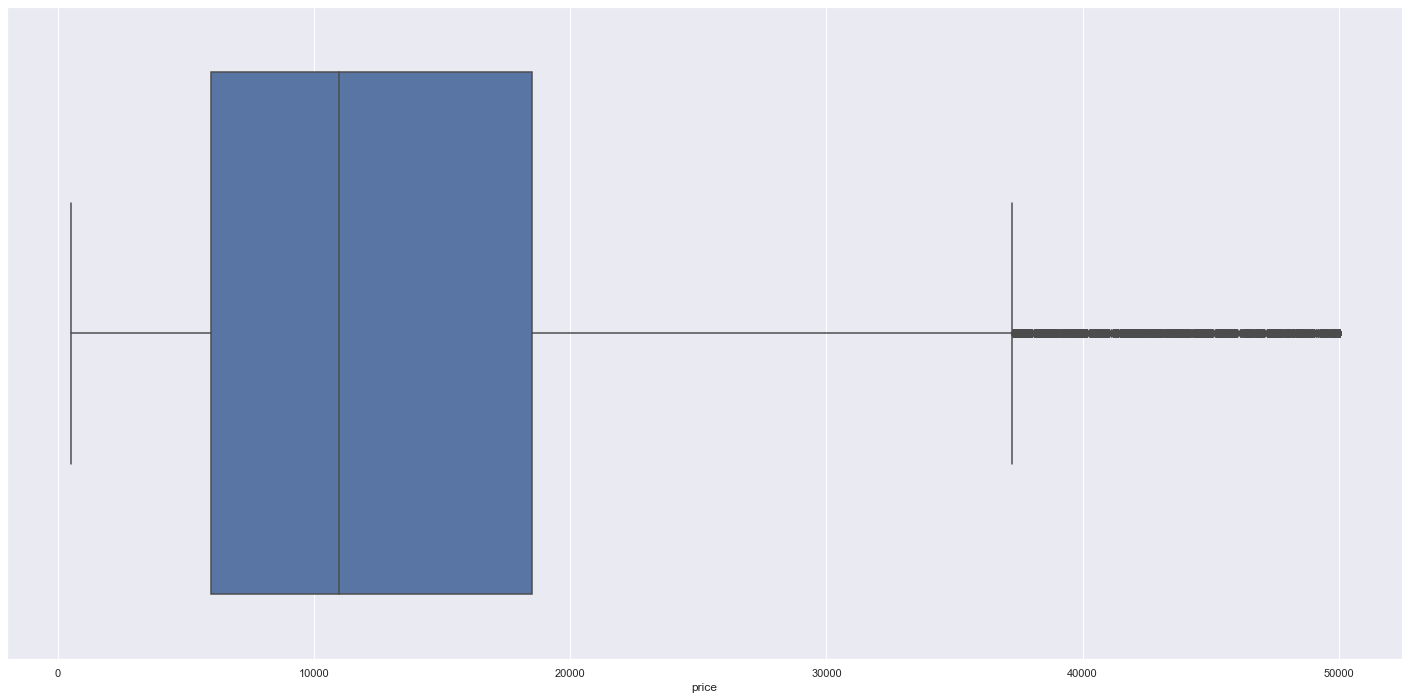

In [12]:
sns.boxplot( df1['price'] )

# We still have outliers, but, as I said earlier, I will deal with them later.
# The goal here is just to solve the noises that might have prevented our project in that first moment.

In [13]:
df1.shape

(390861, 25)

## 1.5 Check NA

In [14]:
df1.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year               839
manufacturer     16650
model             5393
condition       157677
cylinders       143975
fuel              2703
odometer         63633
title_status      1584
transmission      1848
vin             178573
drive           106624
size            264047
type            103913
paint_color     117140
image_url           22
description         24
county          390861
state                0
lat               3333
long              3333
dtype: int64

## 1.6 Fillout NA

In [15]:
# --> year

# The first variable that has an empty value and that I will deal with is the "year".
# Looking at the other variables to be able to see if I can extract some info that helps to fill in the "nan" values, I find that the "description" column has the info year inside it.
# The problem is that there are also "nan" values in the "description" column. The positive info is that there are only 27 empty values in the "description" column.
# I only looked at the observations where "description" is empty and found that, of the 27 empty values, 3 already have the "year" column filled in and the rest have almost no value filled in the other columns.
# My solution is as follows: fill the column "year" with the information contained in the column "description" not empty and drop the entire line in the 24 observations where the column "description" is empty along with several others, as we will not have enough info.
# First of all, I will drop the rows where the columns "year" and "description" are null.
df1.dropna(subset=['year', 'description'], how='all', inplace=True)
df1['year'] = df1.apply( lambda x: x['description'][:5] if math.isnan( x['year'] ) else x['year'], axis=1 )
# After fill the nan values in "year" column, there are some values that aren't year values, such as: '92 to', '03 je', 'Auto' and 'Nice'. I will transform these values by hand.
df1['year'] = df1.apply( lambda x: 1992 if x['year']=='92 to' else x['year'], axis=1 ) # We can see easily that the year is "1992"
df1['year'] = df1.apply( lambda x: 2003 if x['year']=='03 je' else x['year'], axis=1 ) # We can see easily that the year is "2003"
df1.drop(df1.loc[df1['year']=='Auto '].index, inplace=True) # In the description columns don't have any info about the year; so, we will drop the entire row.
df1.drop(df1.loc[df1['year']=='Nice '].index, inplace=True) # In the description columns don't have any info about the year; so, we will drop the entire row.

# --> manufacturer

# I noticed that the "description" and "model" columns have info that can help me fill in the "manufacturer" column.
# How to get the info from the "description" column will be more work at first, I'll try to do a "to" from the "model" column to fill in the "manufacturer" column.
df1['model'] = df1['model'].str.lower() # First I will apply a lower function in the "model" column.
# In the first cicle I will drop que rows that have 'model' and 'manufacturer' with nan values at the same time.
df1.drop( index=df1[df1['manufacturer'].isna() & df1['model'].isna()].index, inplace=True )
# Now I will create a dictionary with the model and its respective manufacturer.
df11 = df1[df1['manufacturer'].notna()]
df12 = df11[df11['model'].notna()]
manufacturer_dict = {}
for k, v in df12[['model', 'manufacturer']].values:
    manufacturer_dict[k] = v
df1['manufacturer'] = df1.apply( lambda x: manufacturer_dict[x['model']] if x['model'] in manufacturer_dict.keys() else x['manufacturer'], axis=1) # reduce the "nan" values to 17848, but not resolved.
# The second attempt to decrease or end "nan" values will be to take the list of manufacturers and check if they are present in the "description" column.
df1['description'] = df1['description'].str.lower()
df1['manufacturer'] = df1.apply( lambda x: x['manufacturer'] if pd.isna( x['description'] ) or pd.notna( x['manufacturer'] )
                                else 'ford' if 'ford' in str(x['description']).split() 
                                else 'chevrolet' if 'chevrolet' in str(x['description']).split() 
                                else 'toyota' if 'toyota' in str(x['description']).split() 
                                else 'nissan' if 'nissan' in str(x['description']).split() 
                                else 'honda' if 'honda' in str(x['description']).split()
                                else 'jeep' if 'jeep' in str(x['description']).split() 
                                else 'gmc' if 'gmc' in str(x['description']).split() 
                                else 'ram' if 'ram' in str(x['description']).split() 
                                else 'dodge' if 'dodge' in str(x['description']).split() 
                                else 'mercedes-benz' if 'mercedes-benz' in str(x['description']).split() 
                                else 'bmw' if 'bmw' in str(x['description']).split() 
                                else 'hyundau' if 'hyundai' in str(x['description']).split() 
                                else 'subaru' if 'subaru' in str(x['description']).split() 
                                else 'volkswagen' if 'volkswagen' in str(x['description']).split() 
                                else 'kia' if 'kia' in str(x['description']).split()
                                else 'chrysler' if 'chrysler' in str(x['description']).split() 
                                else 'cadillac' if 'cadillac' in str(x['description']).split() 
                                else 'lexus' if 'lexus' in str(x['description']).split() 
                                else 'buick' if 'buick' in str(x['description']).split() 
                                else 'mazda' if 'mazda' in str(x['description']).split()
                                else 'audi' if 'audi' in str(x['description']).split() 
                                else 'acura' if 'acura' in str(x['description']).split() 
                                else 'infiniti' if 'infiniti' in str(x['description']).split() 
                                else 'lincoln' if 'lincoln' in str(x['description']).split() 
                                else 'pontiac' if 'pontiac' in str(x['description']).split()
                                else 'volvo' if 'volvo' in str(x['description']).split() 
                                else 'mitsubishi' if 'mitsubishi' in str(x['description']).split() 
                                else 'mini' if 'mini' in str(x['description']).split() 
                                else 'rover' if 'rover' in str(x['description']).split() 
                                else 'mercury' if 'mercury' in str(x['description']).split() 
                                else 'saturn' if 'saturn' in str(x['description']).split() 
                                else 'fiat' if 'fiat' in str(x['description']).split() 
                                else 'jaguar' if 'jaguar' in str(x['description']).split() 
                                else 'tesla' if 'tesla' in str(x['description']).split() 
                                else 'harley-davidson' if 'harley-davidson' in str(x['description']).split()
                                else 'ferrari' if 'ferrari' in str(x['description']).split() 
                                else 'alfa-romeo' if 'alfa-romeo' in str(x['description']).split() 
                                else 'datsun' if 'datsun' in str(x['description']).split() 
                                else 'aston-martin' if 'aston-martin' in str(x['description']).split() 
                                else 'porche' if 'porche' in str(x['description']).split()
                                else 'land rover' if 'land rover' in str(x['description']).split() 
                                else 'morgan' if 'morgan' in str(x['description']).split()
                                else x['manufacturer'], axis=1 ) # reduce the "nan" values to 12514, but not resolved.
# The third and last attempt I will see the values in "model" columns and find a relationtionship between "manufacturer" and "model".
df1['manufacturer'] = df1.apply( lambda x: x['manufacturer'] if pd.isna( x['model'] ) or pd.notna( x['manufacturer'] )
                                else 'gmc' if 'hummer' in str(x['model']).split() 
                                else 'ford' if 'freightliner' in str(x['model']).split() 
                                else 'volkswagen' if 'porsche' in str(x['model']).split() 
                                else 'isuzu' if 'isuzu' in str(x['model']).split() 
                                else 'navistar' if 'internacional ' in str(x['model']).split() 
                                else 'gmc' if 'saab' in str(x['model']).split() 
                                else 'suzuki' if 'suzuki' in str(x['model']).split() 
                                else 'paccar' if 'peterbilt' in str(x['model']).split()
                                else 'volkswagen' if 'jetta' in str(x['model']).split()
                                else 'paccar' if 'kenworth' in str(x['model']).split()
                                else 'chrysler' if 'plymouth' in str(x['model']).split()
                                else 'gmc' if 'oldsmobile' in str(x['model']).split()
                                else 'volkswagen' if 'bentley' in str(x['model']).split()
                                else 'toyota' if 'hino' in str(x['model']).split()
                                else 'gmc' if 'janesville' in str(x['model']).split()
                                else 'bmw' if 'triumph' in str(x['model']).split()
                                else 'chrysler' if 'maserati' in str(x['model']).split()
                                else 'volkswagen' if 'lamborghini' in str(x['model']).split()
                                else 'chevrolet' if 'corvette' in str(x['model']).split()
                                else 'gmc' if 'caddilac' in str(x['model']).split()
                                else 'chevrolet' if 'cheverolet' in str(x['model']).split()
                                else 'hyundau' if 'hyunday' in str(x['model']).split()
                                else 'hyundau' if 'hyundai' in str(x['model']).split()
                                else 'chevrolet' if 'chevorlet' in str(x['model']).split()
                                else 'volkswagen' if 'volkswagon' in str(x['model']).split()
                                else x['manufacturer'], axis=1 ) # reduce the "nan" values to 6068, but not resolved. Thats enought for the first cicle. From the second cycle I can treat data better.

# --> condition

# Check if you have a model with the "condition" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['condition'].notna()]
df12 = df11[df11['model'].notna()]
condition_dict = {}
for k, v in df12[['model', 'condition']].values:
    condition_dict[k] = v
df1['condition'] = df1.apply( lambda x: x['condition'] if pd.isna( x['model'] ) or pd.notna( x['condition'] ) else condition_dict[x['model']] if x['model'] in condition_dict.keys() else x['condition'], axis=1)# 28615 "nan" values left.
# as it can cause confusion between the "like new" and "new" values I will not try to fill in the "nan" values using the ifo's in the "description" variable.

# --> cylinders

# Check if you have a model with the "cylinders" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['cylinders'].notna()]
df12 = df11[df11['model'].notna()]
cylinders_dict = {}
for k, v in df12[['model', 'cylinders']].values:
    cylinders_dict[k] = v
df1['cylinders'] = df1.apply( lambda x: x['cylinders'] if pd.isna( x['model'] ) or pd.notna( x['cylinders'] ) else cylinders_dict[x['model']] if x['model'] in cylinders_dict.keys() else x['cylinders'], axis=1)# 29022 "nan" values remain.
# Since the values inside the "cylinders" variable have space between them, they can cause errors in filling in the "nan" values using the "split" function.

# --> fuel

# As it can happen that the same car model has several possibilities for "fuel" I will not use the search formula in the "model" variable.
# Check and there is a "fuel" value within the "description" variable. In order not to cause an error in filling in the "nan" values, I will not use the "other" value.
df1['fuel'] = df1.apply( lambda x: x['fuel'] if pd.isna( x['description'] ) or pd.notna( x['fuel'] )
                                else 'gas' if 'gas' in str(x['description']).split() 
                                else 'diesel' if 'diesel' in str(x['description']).split() 
                                else 'hybrid' if 'hybrid' in str(x['description']).split() 
                                else 'electric' if 'electric' in str(x['description']).split()
                                else x['fuel'], axis=1 ) # 2152 "nan" values left.

# --> odometer

# Trying to stipulate the value as close to reality as possible, I will fill in the "nan" values by separating this variable by the "year" column and calculating the median to try to prevent the value from being affected by possible outliers.
df1['odometer'] = df1['odometer'].fillna(df1.groupby('year')['odometer'].transform('median'))
# Since there are only 40 empty values left, I will drop all 40 lines that have "nan" values in the "odometer" column.
df1.drop(df1[df1['odometer'].isna()].index, inplace=True)

# --> title_status

# Since the values of this variable are difficult to identify effectively through queries to other columns and the total "nan" values are low, I will directly fill in the "nan" values with "other".
#df1['title_status'].fillna( 'other', inplace=True )

# --> transmission

# As it can happen that the same car model has several transmission possibilities, I will not use the search formula in the variable "model".
# Check and there is the value of "transmission" inside the variable "description". In order not to cause an error in filling in the "nan" values, I will not use the "other" value.
df1['transmission'] = df1.apply( lambda x: x['transmission'] if pd.isna( x['description'] ) or pd.notna( x['transmission'] )
                                else 'automatic' if 'automatic' in str(x['description']).split() 
                                else 'manual' if 'manual' in str(x['description']).split()
                                else x['transmission'], axis=1 ) # 1812 "nan" values remain.

# --> drive

# Check if you have a model with the "drive" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['drive'].notna()]
df12 = df11[df11['model'].notna()]
drive_dict = {}
for k, v in df12[['model', 'drive']].values:
    drive_dict[k] = v
df1['size'] = df1.apply( lambda x: x['drive'] if pd.isna( x['model'] ) or pd.notna( x['drive'] ) else drive_dict[x['model']] if x['model'] in drive_dict.keys() else x['drive'], axis=1)# 18125 "nan" values remain.
# Check and there is a "drive" value inside the "description" variable.
df1['drive'] = df1.apply( lambda x: x['drive'] if pd.isna( x['description'] ) or pd.notna( x['drive'] )
                                else '4wd' if '4wd' in str(x['description']).split() 
                                else 'fwd' if 'fwd' in str(x['description']).split() 
                                else 'rwd' if 'rwd' in str(x['description']).split() 
                                else x['drive'], axis=1 ) # did not fill in any "nan" values.

# --> size

# Check if you have a model with the "size" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['size'].notna()]
df12 = df11[df11['model'].notna()]
size_dict = {}
for k, v in df12[['model', 'size']].values:
    size_dict[k] = v
df1['size'] = df1.apply( lambda x: x['size'] if pd.isna( x['model'] ) or pd.notna( x['size'] ) else size_dict[x['model']] if x['model'] in size_dict.keys() else x['size'], axis=1)
# Check and there is a "size" value inside the "description" variable.
df1['size'] = df1.apply( lambda x: x['size'] if pd.isna( x['description'] ) or pd.notna( x['size'] )
                                else 'full-size' if 'full-size' in str(x['description']).split() 
                                else 'mid-size' if 'mid-size' in str(x['description']).split() 
                                else 'compact' if 'compact' in str(x['description']).split() 
                                else 'sub-compact' if 'sub-compact' in str(x['description']).split() 
                                else x['size'], axis=1 )

# --> type

# Check if you have a model with the "type" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['type'].notna()]
df12 = df11[df11['model'].notna()]
type_dict = {}
for k, v in df12[['model', 'type']].values:
    type_dict[k] = v
df1['type'] = df1.apply( lambda x: x['type'] if pd.isna( x['model'] ) or pd.notna( x['type'] ) else type_dict[x['model']] if x['model'] in type_dict.keys() else x['type'], axis=1)# 17472 "nan" values remain.
# Check and there is the value of "type" inside the variable "description".
df1['type'] = df1.apply( lambda x: x['type'] if pd.isna( x['description'] ) or pd.notna( x['type'] )
                                else 'SUV' if 'SUV' in str(x['description']).split() 
                                else 'sedan' if 'sedan' in str(x['description']).split() 
                                else 'pickup' if 'pickup' in str(x['description']).split() 
                                else 'truck' if 'truck' in str(x['description']).split() 
                                else 'coupe' if 'coupe ' in str(x['description']).split() 
                                else 'hatchback' if 'hatchback' in str(x['description']).split() 
                                else 'van' if 'van' in str(x['description']).split() 
                                else 'wagon' if 'wagon' in str(x['description']).split()
                                else 'convertible' if 'convertible' in str(x['description']).split()
                                else 'mini-van' if 'mini-van' in str(x['description']).split()
                                else 'offroad' if 'offroad' in str(x['description']).split()
                                else 'bus' if 'bus' in str(x['description']).split()
                                else x['type'], axis=1 )# 10685 "nan" values left.

# --> paint-color

# As it can happen that the same car model has several possibilities of "paint-color" I will not use the search formula in the variable "model".
# Check and there is the value of "paint-color" inside the variable "description".
df1['paint_color'] = df1.apply( lambda x: x['paint_color'] if pd.isna( x['description'] ) or pd.notna( x['paint_color'] )
                                else 'white' if 'white' in str(x['description']).split() 
                                else 'black' if 'black' in str(x['description']).split() 
                                else 'silver' if 'silver' in str(x['description']).split() 
                                else 'blue' if 'blue' in str(x['description']).split() 
                                else 'grey' if 'grey ' in str(x['description']).split() 
                                else 'red' if 'red' in str(x['description']).split() 
                                else 'green' if 'green' in str(x['description']).split() 
                                else 'custom' if 'custom' in str(x['description']).split()
                                else 'brown' if 'brown' in str(x['description']).split()
                                else 'yellow' if 'yellow' in str(x['description']).split()
                                else 'orange' if 'orange' in str(x['description']).split()
                                else 'purple' if 'purple' in str(x['description']).split()
                                else x['paint_color'], axis=1 ) # 89241 "nan" values left.

# --> lat and long

# Since "lat" and "long" are directly related to "region" I will separate them by "region" and average "lat" and "long".
# Here, unlike what was done in the "odometer" variable, there is no need to use the median because the variation in this case will be very small.
df1['lat'] = df1['lat'].fillna(df1.groupby('region')['lat'].transform('mean'))
df1['long'] = df1['long'].fillna(df1.groupby('region')['long'].transform('mean')) # no missing values left.

# --> id

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['id'], axis=1, inplace=True )

# --> url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['url'], axis=1, inplace=True )

# --> region_url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['region_url'], axis=1, inplace=True )

# --> model

# That column has a lot of polluted data and it would take months of work to try to correct it one by one. As I have a lot of variables with good potentials in this dataset I will choose to drop this column. 
# If the model does not perform well in the end, in the next cycles I will study the possibility of treating this column better.
# I think it is worse for the project to delete only the nan rows, but keeping the column, than to delete the entire column and not decrease the number of observations in our dataset.
df1.drop( ['model'], axis=1, inplace=True )

# --> vin

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['vin'], axis=1, inplace=True )

# --> image_url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['image_url'], axis=1, inplace=True )

# --> description

# This variable is not relevant to the project, but it was extremely important in helping to fill in the "nan" values in other columns. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['description'], axis=1, inplace=True )

# --> county

# All the "county" column have null value. I will drop this column.
df1.drop( ['county'], axis=1, inplace=True )

In [16]:
df1.isna().sum()

region              0
price               0
year                0
manufacturer     4689
condition       23431
cylinders       24253
fuel             2009
odometer            0
title_status     1562
transmission     1537
drive           95659
size            13849
type             8490
paint_color     78899
state               0
lat                 0
long                0
dtype: int64

In [17]:
# In this first cycle, as I have a lot of data, I will choose to remove from the dataset all observations that have null values. 
# Depending on the model's performance at the end of this project, I will think of other ways to treat them from the second cycle.
df1.dropna(inplace=True)

In [18]:
df1.shape

(239372, 17)

## 1.7 Change Types

In [19]:
# Check if, after the treatment of the "nan" values, there was any problem of data types.
df1.dtypes

region           object
price             int64
year             object
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
dtype: object

In [20]:
# year
df1['year'] = df1['year'].astype( 'int64' )

In [21]:
# That's all correct!
df1.dtypes

region           object
price             int64
year              int64
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
dtype: object

## 1.8 Descriptive Statistical

In [22]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

In [23]:
num_attributes.sample()

,price,year,odometer,lat,long
256873,10900,2013,95569.0,39.3912,-88.9642


In [24]:
cat_attributes.sample()

,region,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
52136,corvallis/albany,ford,good,8 cylinders,diesel,clean,automatic,4wd,4wd,truck,black,or


### 1.7.1 Numerical Attributes

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [26]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,502.0000,4.999900e+04,4.949700e+04,13723.340796,11500.0000,9477.875730,1.117098,0.996404
1,year,1900.0000,2.021000e+03,1.210000e+02,2010.118539,2012.0000,8.355683,-3.508744,20.691449
2,odometer,0.0000,1.000000e+07,1.000000e+07,103261.343027,98000.0000,110114.923172,48.467902,3972.648988
3,lat,-83.1971,6.700220e+01,1.501993e+02,38.710801,39.4600,5.957104,-0.161324,5.495794
4,long,-161.8750,1.393880e+02,3.012630e+02,-94.608143,-88.8112,18.164706,-0.702689,1.778890


<AxesSubplot:xlabel='price'>

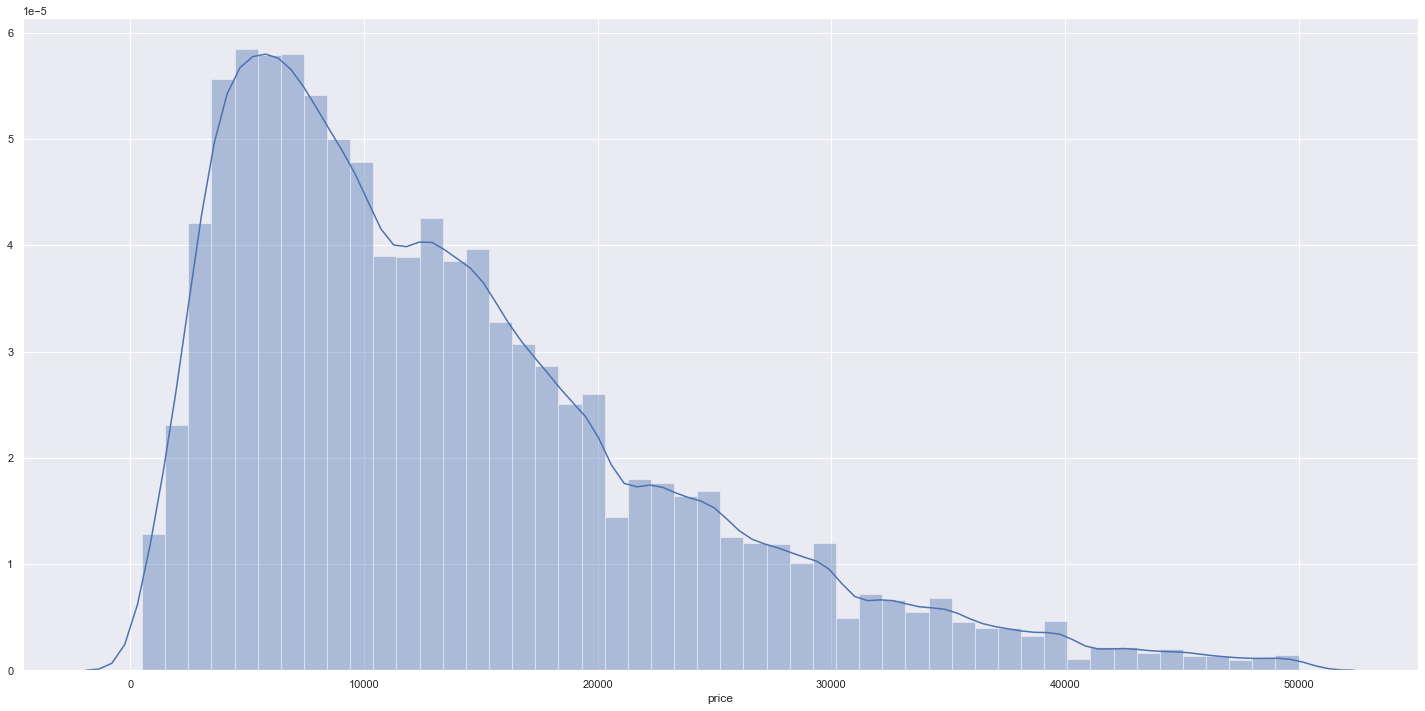

In [27]:
sns.distplot( df1['price'] )
# Observing the distribution of the target variable, we can already see the presence of outliers. This problem will be addressed later.

### 1.7.2. Categorical Attributes

In [28]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

region          402
manufacturer     46
condition         6
cylinders         8
fuel              5
title_status      6
transmission      3
drive             3
size              5
type             13
paint_color      12
state            51
dtype: int64

<AxesSubplot:xlabel='state', ylabel='price'>

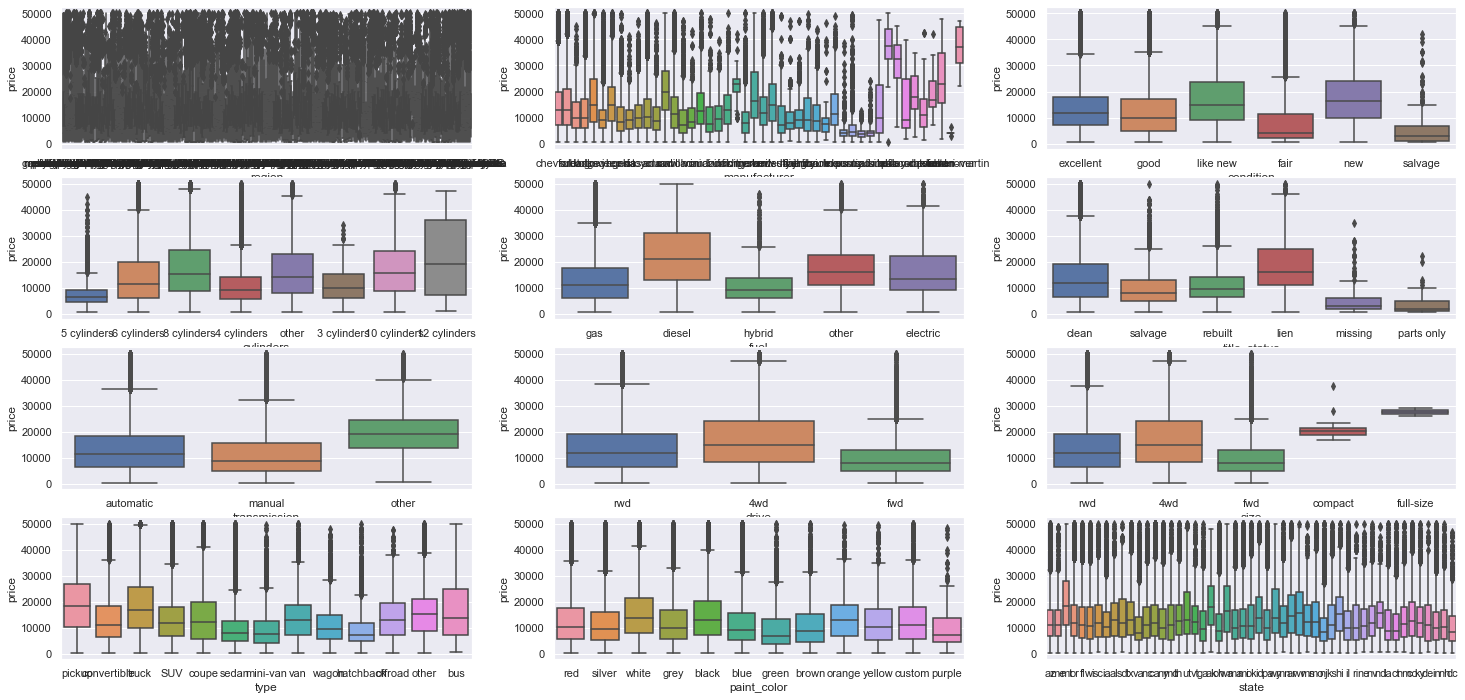

In [29]:
aux1 = df1[ df1['price'] > 0 ]


plt.subplot(4, 3, 1)
sns.boxplot( x= 'region', y='price' , data=aux1 )

plt.subplot(4, 3, 2)
sns.boxplot( x= 'manufacturer', y='price' , data=aux1 )

plt.subplot(4, 3, 3)
sns.boxplot( x= 'condition', y='price' , data=aux1 )

plt.subplot(4, 3, 4)
sns.boxplot( x= 'cylinders', y='price' , data=aux1 )

plt.subplot(4, 3, 5)
sns.boxplot( x= 'fuel', y='price' , data=aux1 )

plt.subplot(4, 3, 6)
sns.boxplot( x= 'title_status', y='price' , data=aux1 )

plt.subplot(4, 3, 7)
sns.boxplot( x= 'transmission', y='price' , data=aux1 )

plt.subplot(4, 3, 8)
sns.boxplot( x= 'drive', y='price' , data=aux1 )

plt.subplot(4, 3, 9)
sns.boxplot( x= 'size', y='price' , data=aux1 )

plt.subplot(4, 3, 10)
sns.boxplot( x= 'type', y='price' , data=aux1 )

plt.subplot(4, 3, 11)
sns.boxplot( x= 'paint_color', y='price' , data=aux1 )

plt.subplot(4, 3, 12)
sns.boxplot( x= 'state', y='price' , data=aux1 )

# The same thing observed in the numerical data can be found in the ategorical data as well: The strong presence of outliers in the dataset. 
# It is even difficult to visualize the distribution of categorical variables.

# 2.0 STEP 02 - FEATURE ENGINEERING

In [30]:
df2 = df1.copy()

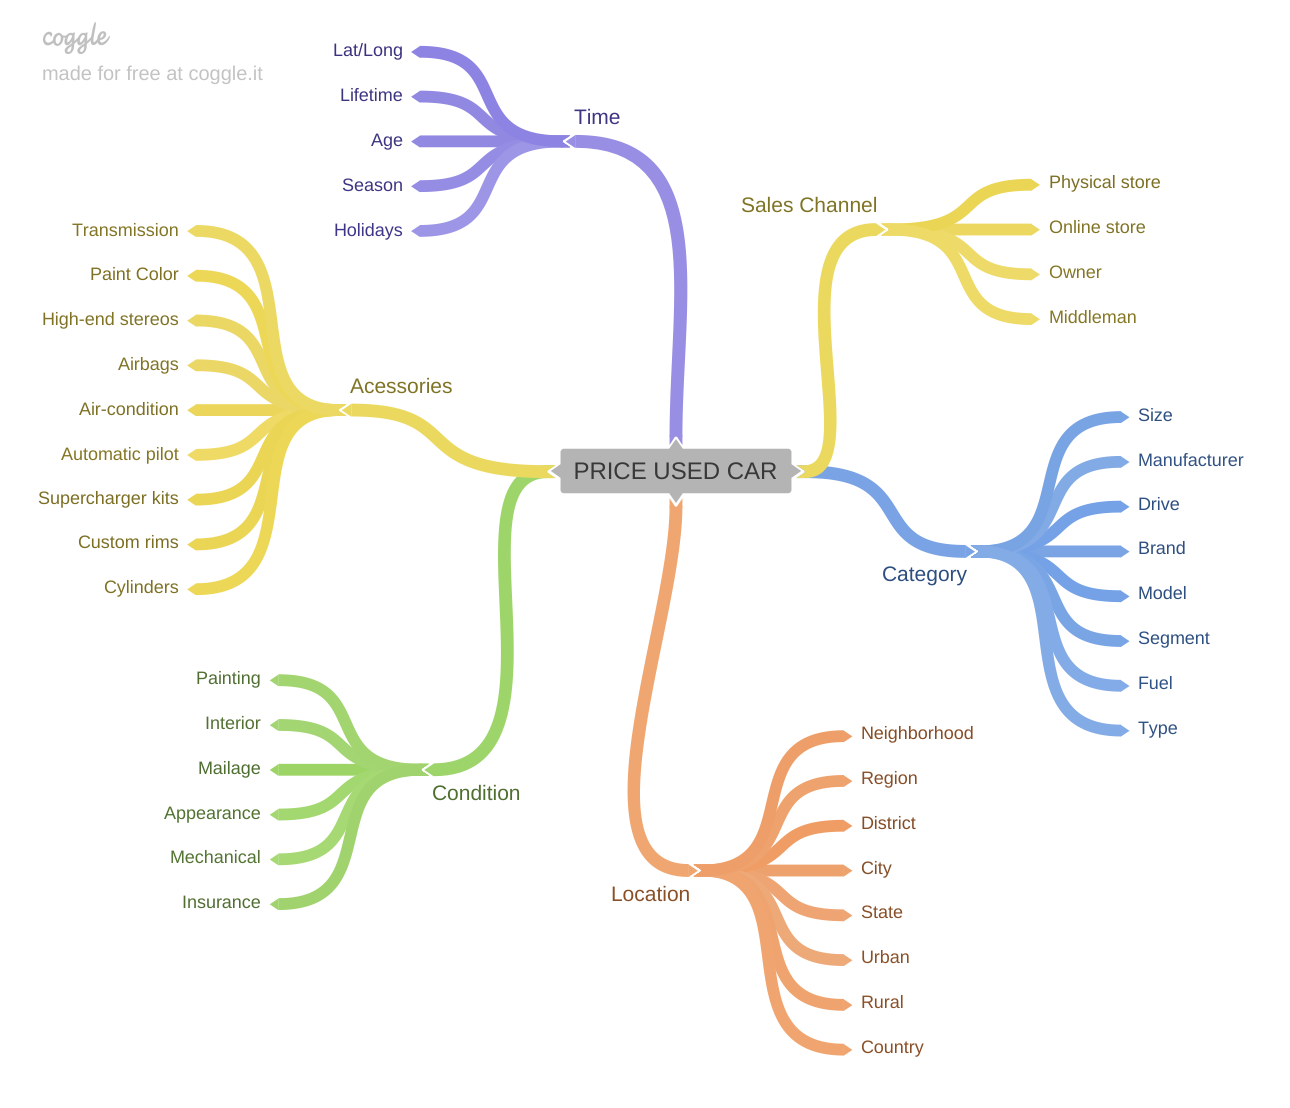

In [31]:
Image( "image/Hyphoteses_Map.png")

# To guide us in the process of exploratory data analysis I created a driagram that shows the agents and their attributes that can affect the press of used cars.

## 2.1 Creation of Hyphoteses

### 2.1.1 Condition Hyphoteses

**1.** Used cars with silver or black painting should be expensive.

**2.** Used cars which has interior with good condition should be expensive.

**3.** Used cars with high Mailage should be cheaper.

**4.** Used cars with better Appearance should be expensive.

**5.** Used cars wich has a good Mechanical should be expensive.

**6.** Used cars with any Insurance should be cheaper.

### 2.1.2 Location Hyphoteses

**1.** Used cars located in periphery neighborhood should be cheaper.

**2.** Used cars in west or northeast regions should cost more.

**3.** Used cars located in rich cities should be expensive.

**4.** Used cars in rich States should cost more.

**5.** Used cars that are in urban environments should be expensive.

**6.** Used cars that are in rural environments should cost less.

**7.** Used cars that come from another country should cost more.

### 2.1.3 Category Hyphoteses

**1.** Used cars with less size should be cheaper.

**2.** Used cars which come from big manufacturer should be cost more.

**3.** Used cars with 4wd drive should be cost more.

**4.** Used cars belongs to luxury segment should cost more.

**5.** Used cars with electric fuel should be expensive.

**6.** Used cars with SUV, pickup or truck type should cost more.

### 2.1.4 Acessories Hyphoteses

**1.** Used cars with automatic transmission should be cost more.

**2.** Used cars with silver or black paint-color should be expensive.

**3.** Used cars with high-end stereos should be expensive.

**4.** Used cars with less Airbags should be cheaper.

**5.** Used cars with air-condition should cost more.

**6.** Used cars with automatic pilot should cost more.

**7.** Used cars with supercharger kits should cost more.

**8.** Used cars with custom rims should cost more.

**9.** Used cars with more cylinders should be expensive.

### 2.1.5 Time Hyphoteses

**1.** Used cars with Lat/Long loacated in cost areas should cost more.

**2.** Used cars which has lifetime longer should be cheaper.

**3.** Used cars with less age should cost less.

**4.** Used cars selling in summer or winter season should be expensive.

**5.** Used cars selling in holidays should be expensive.

### 2.1.6 Sales Channel Hyphoteses

**1.** Used cars selling in physical store.

**2.** Used cars selling in online store should be cheaper.

**3.** Used cars selling through an owner should be cheaper.

**4.** Used cars selling through a middleman should be expensive.

## 2.2 Final List of Hyphoteses

In [32]:
# Based on some criteria, such as: information already available in the dataset and data that would be available at the beginning of the collection process. 
# I created a final list of hypotheses that, in a possible second cycle, can increase when I include another item from the previously made list.

**1.** Used cars with high Mailage should be cheaper.

**2.** Used cars with better Appearance should be expensive.

**3.** Used cars in west or northeast regions should cost more.

**4.** Used cars in rich States should cost more.

**5.** Used cars which come from big manufacturer should be cost more.

**6.** Used cars with 4wd drive should be cost more.

**7.** Used cars with electric fuel should be expensive.

**8.** Used cars with SUV, pickup or truck type should cost more.

**9.** Used cars with automatic transmission should be cost more.

**10.** Used cars with silver or black paint-color should be expensive.

**11.** Used cars with more cylinders should be expensive.

**12.** Used cars with Lat/Long loacated in cost areas should cost more.

**13.** Used cars with less age should cost less.

## 2.3 Feature Engineering

In [33]:
# First of all I will change the column name "region" to "city" name because this last one is more correct according to column content.
df2.rename( columns={"region": "city"}, inplace=True )

# region
# Create a new column named "region" which included the regions of USA, such as: northeast, midwest, south and west
# Northeast: ct, me, ma, nh, ri, vt, nj, ny, and pa
# Midwest: il, in, mi, oh, wi, ia, ks, mn, mo, ne, nd, and sd
# South: de, fl, ga, md, nc, sc, va, dc, wv, al, ky, ms, tn, ar, la, ok, and tx
# West: az, co, id, mt, nv, nm, ut, wy, ak, ca, hi, or, and wa

df2['region'] = df2['state'].replace( {"ct": "northeast", "me": "northeast", "ma": "northeast", "nh": "northeast", "ri": "northeast", "vt": "northeast", "nj": "northeast", "ny": "northeast", "pa": "northeast", "il": "midwest", 
                                       "in": "midwest", "mi": "midwest", "oh": "midwest", "wi": "midwest", "ia": "midwest", "ks": "midwest", "mn": "midwest", "mo": "midwest", "ne": "midwest", "nd": "midwest", "sd": "midwest",
                                       "de":"south", "fl":"south", "ga":"south", "md":"south", "nc":"south", "sc":"south", "va":"south", "dc":"south", "wv":"south", "al":"south", "ky":"south", "ms":"south", "tn":"south", 
                                       "ar":"south", "la":"south", "ok":"south", "tx":"south", "az":"west", "co":"west", "id":"west", "mt":"west", "nv":"west", "nm":"west", "ut":"west", "wy":"west", "ak":"west", "ca":"west",
                                       "hi":"west", "or":"west", "wa":"west"} )

# city
df2['city'] = df2['city'].str.lower()

# type
df2['type'] = df2['type'].str.lower()

# manufacturer
df2['manufacturer'] = df2['manufacturer'].apply( lambda x: 'hyundai' if x=='hyundau' else x )

In [34]:
df2.head().T

,3,7,12,19,20
city,mohave county,maine,maine,helena,oregon coast
price,9000,8500,2750,24930,6995
year,2004,2005,2006,2017,2009
manufacturer,chevrolet,ford,chevrolet,subaru,dodge
condition,excellent,excellent,good,excellent,excellent
cylinders,5 cylinders,6 cylinders,8 cylinders,4 cylinders,6 cylinders
fuel,gas,gas,gas,gas,gas
odometer,54000,62800,165000,32989,106898
title_status,clean,clean,clean,clean,clean
transmission,automatic,automatic,automatic,automatic,automatic


# 3.0 STEP 03 - VARIABLE FILTERING

In [35]:
df3 = df2.copy()

In [36]:
df3.head()

,city,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,region
3,mohave county,9000,2004,chevrolet,excellent,5 cylinders,gas,54000.0,clean,automatic,rwd,rwd,pickup,red,az,34.4783,-114.2710,west
7,maine,8500,2005,ford,excellent,6 cylinders,gas,62800.0,clean,automatic,rwd,rwd,convertible,silver,me,44.2070,-69.7858,northeast
12,maine,2750,2006,chevrolet,good,8 cylinders,gas,165000.0,clean,automatic,4wd,4wd,truck,white,me,43.2899,-70.8550,northeast
19,helena,24930,2017,subaru,excellent,4 cylinders,gas,32989.0,clean,automatic,4wd,4wd,suv,grey,mt,45.6546,-110.5610,west
20,oregon coast,6995,2009,dodge,excellent,6 cylinders,gas,106898.0,clean,automatic,fwd,fwd,suv,black,or,45.5231,-122.5790,west


## 3.1 Line Filtering

In [37]:
# There are two columns which have strange values. The "price" and "odometer" variables have zero values and some very low numbers in its content.
# In this first cycle I will drop only the zero values in both columns.
df3 = df3[(df3['price']!=0) | (df3['odometer']!=0.0)]

## 3.2 Column Selection

In [38]:
# The columns that don't have relevance in this first cycle of the project, I already removed in STEP 01 when I filled tha NaN values.
# The only column that I will drop here is the "size" column because this variable has values that don't represent correctly, such as: 4ws, fwd and rwd.
df3.drop( ['size'], axis=1, inplace=True )

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [39]:
df4 = df3.copy()

## 4.1 Univariable Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='price'>

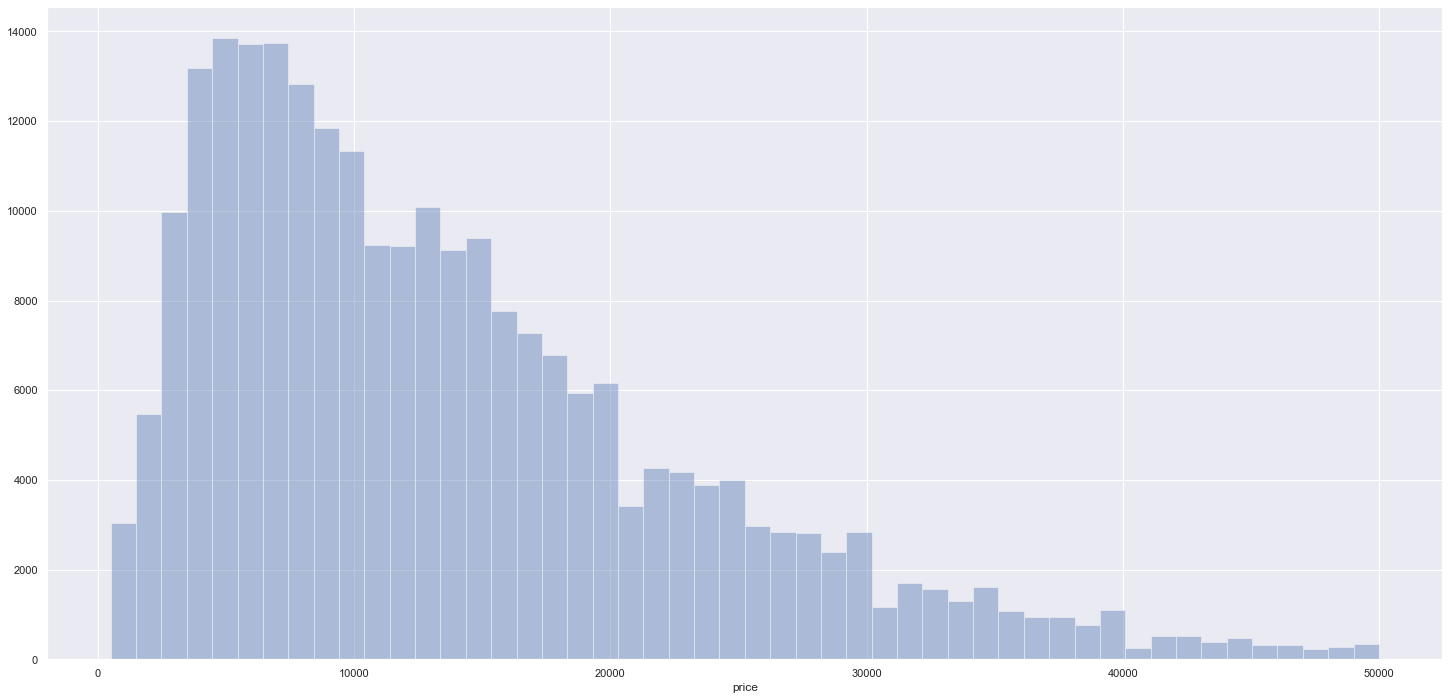

In [40]:
sns.distplot( df4['price'], kde=False )

In [41]:
# As we can see above, the dataset has a lot of outliers.
# Now, I will drop the outliers using the formula below:
# Q1 - 1.5*IQR to inferior limit
# Q3 + 1.5*IQR to superior limit

Q1 = np.quantile(df4['price'],0.25)
Q3 = np.quantile(df4['price'],0.75)
IQR = Q3 - Q1

inferior_limit = Q1 - 1.5*IQR
superior_limit = Q3 + 1.5*IQR

df4 = df4[(df4['price']>inferior_limit) & (df4['price']<superior_limit)]
df4 = df4[(df4['price']!=0) | (df4['odometer']!=0)]

<AxesSubplot:xlabel='price'>

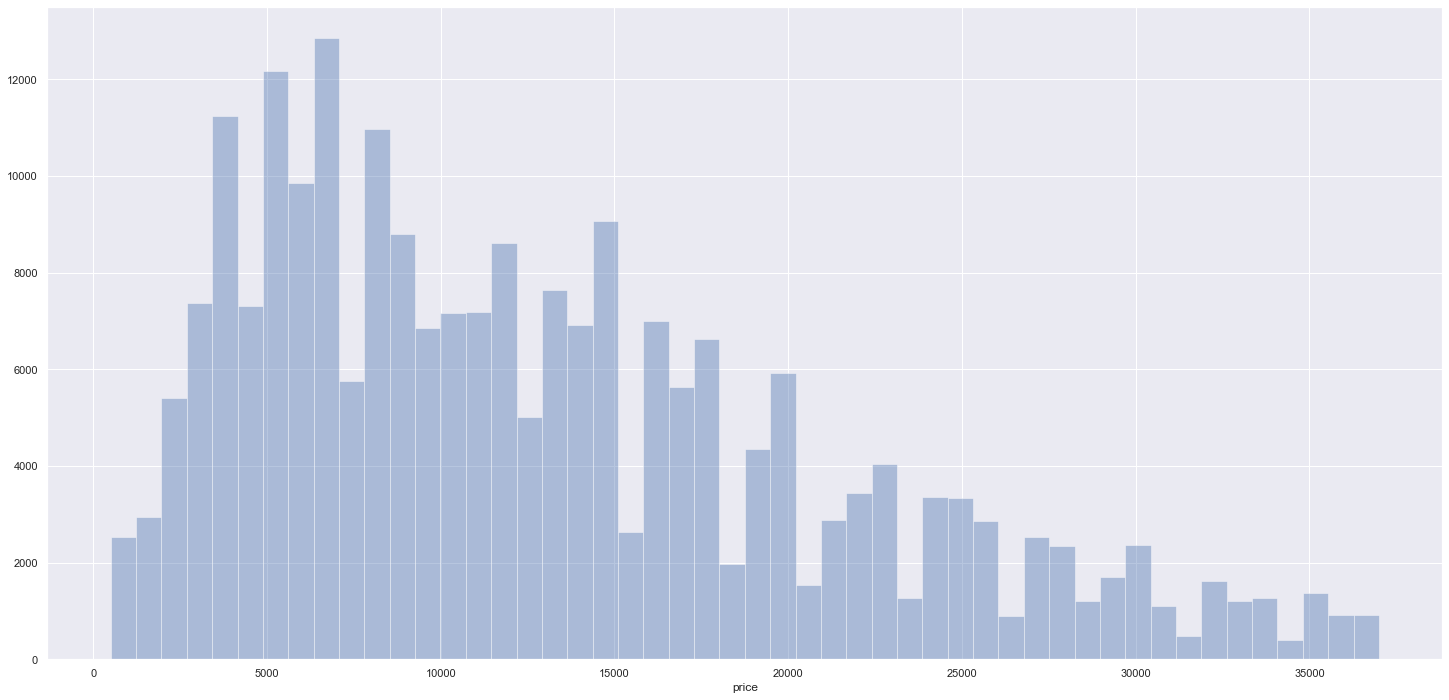

In [42]:
sns.distplot( df4['price'], kde=False )
# To better understand the shape of the response variable, I took some possible outliers.
# I still haven't removed the outliers because I want to use them at EDA and see if some of them can define the value of cars that are worth much above the market average and that in a way can contribute to our project.

### 4.1.2 Numerical Variable

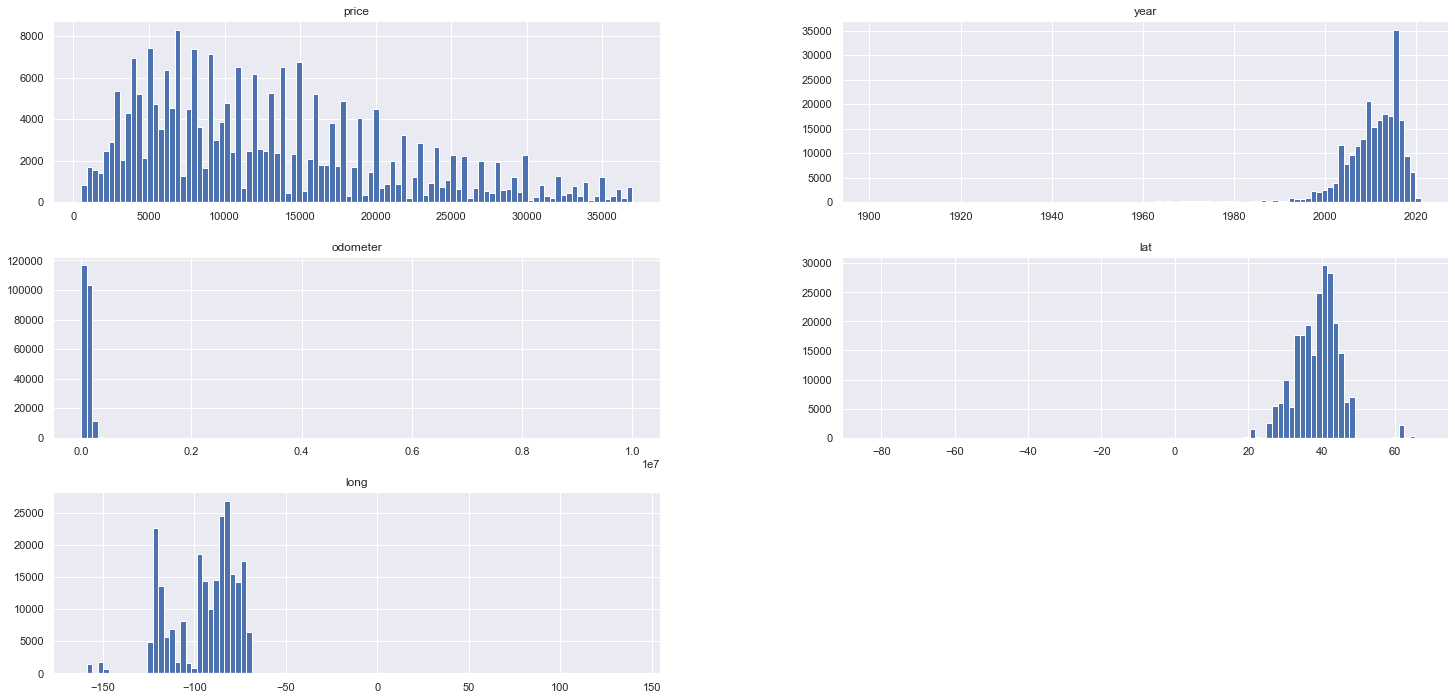

In [43]:
# After the Feature Engineering let's reset the numerical attributes.

num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
num_attributes.hist( bins=100 );

### 4.1.3 Categorical Variable

In [44]:
# After the Feature Engineering let's reset the categorical attributes.

cat_attributes = df4.select_dtypes( exclude=['int64', 'float64'] )
cat_attributes.head()

,city,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state,region
3,mohave county,chevrolet,excellent,5 cylinders,gas,clean,automatic,rwd,pickup,red,az,west
7,maine,ford,excellent,6 cylinders,gas,clean,automatic,rwd,convertible,silver,me,northeast
12,maine,chevrolet,good,8 cylinders,gas,clean,automatic,4wd,truck,white,me,northeast
19,helena,subaru,excellent,4 cylinders,gas,clean,automatic,4wd,suv,grey,mt,west
20,oregon coast,dodge,excellent,6 cylinders,gas,clean,automatic,fwd,suv,black,or,west


In [45]:
df4['region'].drop_duplicates()

3          west
7     northeast
54        south
60      midwest
Name: region, dtype: object

In [46]:
df4['manufacturer'].drop_duplicates()

3               chevrolet
7                    ford
19                 subaru
20                  dodge
22                    gmc
26             volkswagen
29                   jeep
31                  honda
38                    kia
39                 nissan
41                 toyota
42                  acura
44                    ram
54               cadillac
62                  volvo
64                   mini
73                   audi
79                  mazda
119                 buick
166              infiniti
181                morgan
205              chrysler
206                 rover
207                   bmw
220         mercedes-benz
263            mitsubishi
370                  fiat
403               hyundai
431                jaguar
433               lincoln
649                 lexus
848               mercury
1111              pontiac
1557               suzuki
2010               saturn
7893                isuzu
10372               tesla
17760              paccar
18023       

In [47]:
df4['condition'].drop_duplicates()

3      excellent
12          good
31      like new
85          fair
562          new
716      salvage
Name: condition, dtype: object

In [48]:
df4['cylinders'].drop_duplicates()

3        5 cylinders
7        6 cylinders
12       8 cylinders
19       4 cylinders
385      3 cylinders
504     10 cylinders
1809    12 cylinders
2068           other
Name: cylinders, dtype: object

In [49]:
df4['fuel'].drop_duplicates()

3            gas
75        diesel
189       hybrid
266        other
1831    electric
Name: fuel, dtype: object

In [50]:
df4['title_status'].drop_duplicates()

3            clean
76         salvage
81         rebuilt
273           lien
728        missing
6061    parts only
Name: title_status, dtype: object

In [51]:
df4['transmission'].drop_duplicates()

3     automatic
26       manual
31        other
Name: transmission, dtype: object

In [52]:
df4['drive'].drop_duplicates()

3     rwd
12    4wd
20    fwd
Name: drive, dtype: object

In [53]:
df4['type'].drop_duplicates()

3            pickup
7       convertible
12            truck
19              suv
26            coupe
27            sedan
118        mini-van
120             van
191           wagon
241       hatchback
346         offroad
452           other
1204            bus
Name: type, dtype: object

In [54]:
df4['paint_color'].drop_duplicates()

3         red
7      silver
12      white
19       grey
20      black
26       blue
29      green
197     brown
263    orange
509    yellow
681    custom
905    purple
Name: paint_color, dtype: object

In [55]:
df4['state'].drop_duplicates()

3         az
7         me
19        mt
20        or
54        fl
60        wi
73        sc
169       ia
271       al
272       sd
350       tx
401       va
1003      nc
2496      ca
2576      ny
3408      md
3783      tn
5201      ut
9710      vt
12923     ga
16236     ak
17312     oh
19181     wa
19629     ma
23428     mi
27046     ok
27344     id
27353     pa
30888     wy
37068     mn
43536     ar
48865     wv
54472     ms
56147     mo
66795     nj
68831     ks
72394     hi
74224     il
76533     ri
88827     ne
90200     nv
96421     nd
101419    la
101967    ct
102122    nm
109276    co
111259    ky
148962    de
160378    in
223007    nh
251196    dc
Name: state, dtype: object

<AxesSubplot:>

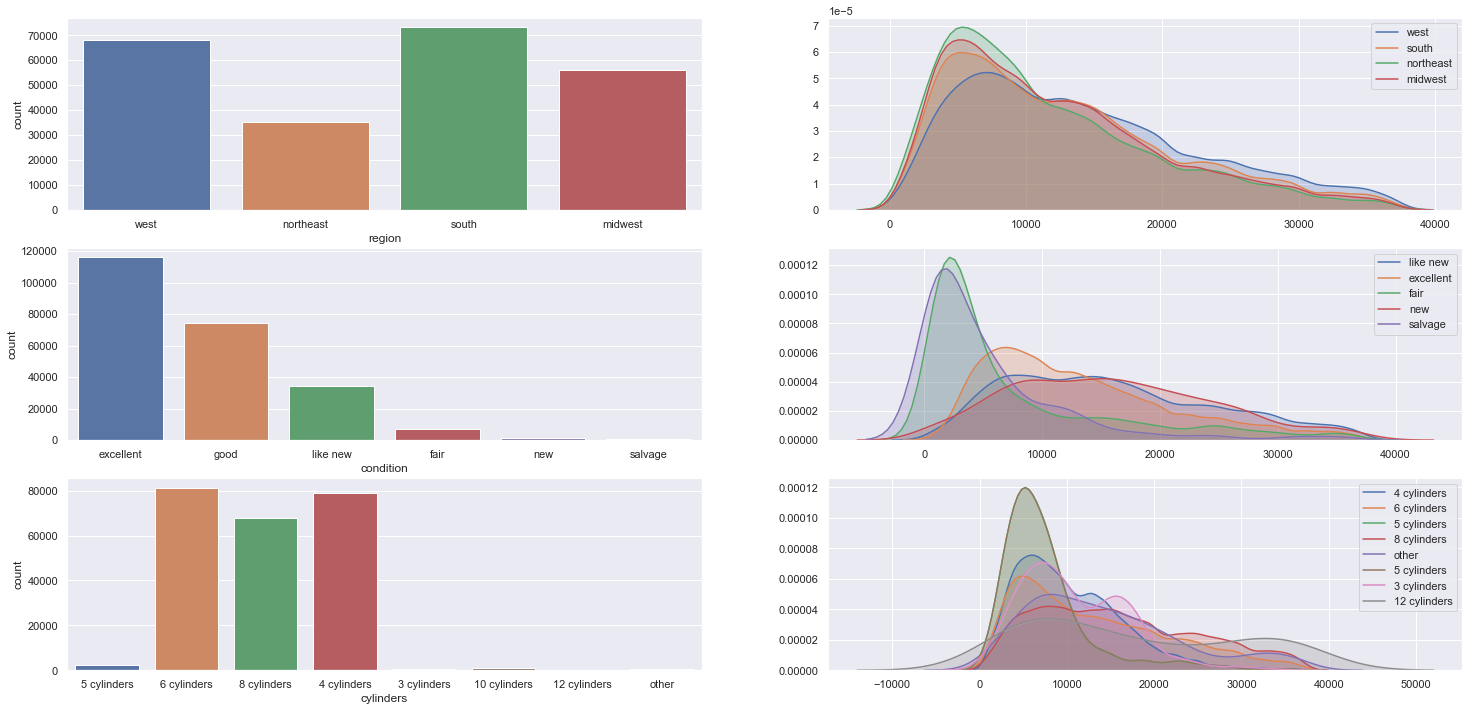

In [56]:
# region

plt.subplot( 3, 2, 1)
sns.countplot( df4['region'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['region'] == 'west']['price'], label='west', shade=True )
sns.kdeplot( df4[df4['region'] == 'south']['price'], label='south', shade=True )
sns.kdeplot( df4[df4['region'] == 'northeast']['price'], label='northeast', shade=True )
sns.kdeplot( df4[df4['region'] == 'midwest']['price'], label='midwest', shade=True )

# condition

plt.subplot( 3, 2, 3)
sns.countplot( df4['condition'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['condition'] == 'like new']['price'], label='like new', shade=True )
sns.kdeplot( df4[df4['condition'] == 'excellent']['price'], label='excellent', shade=True )
sns.kdeplot( df4[df4['condition'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['condition'] == 'fair']['price'], label='fair', shade=True )
sns.kdeplot( df4[df4['condition'] == 'new']['price'], label='new', shade=True )
sns.kdeplot( df4[df4['condition'] == 'salvage']['price'], label='salvage', shade=True )

# cylinders

plt.subplot( 3, 2, 5)
sns.countplot( df4['cylinders'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['cylinders'] == '4 cylinders']['price'], label='4 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '6 cylinders']['price'], label='6 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '5 cylinders']['price'], label='5 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '8 cylinders']['price'], label='8 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '5 cylinders']['price'], label='5 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '3 cylinders']['price'], label='3 cylinders', shade=True )
sns.kdeplot( df4[df4['cylinders'] == '12 cylinders']['price'], label='12 cylinders', shade=True )

<AxesSubplot:>

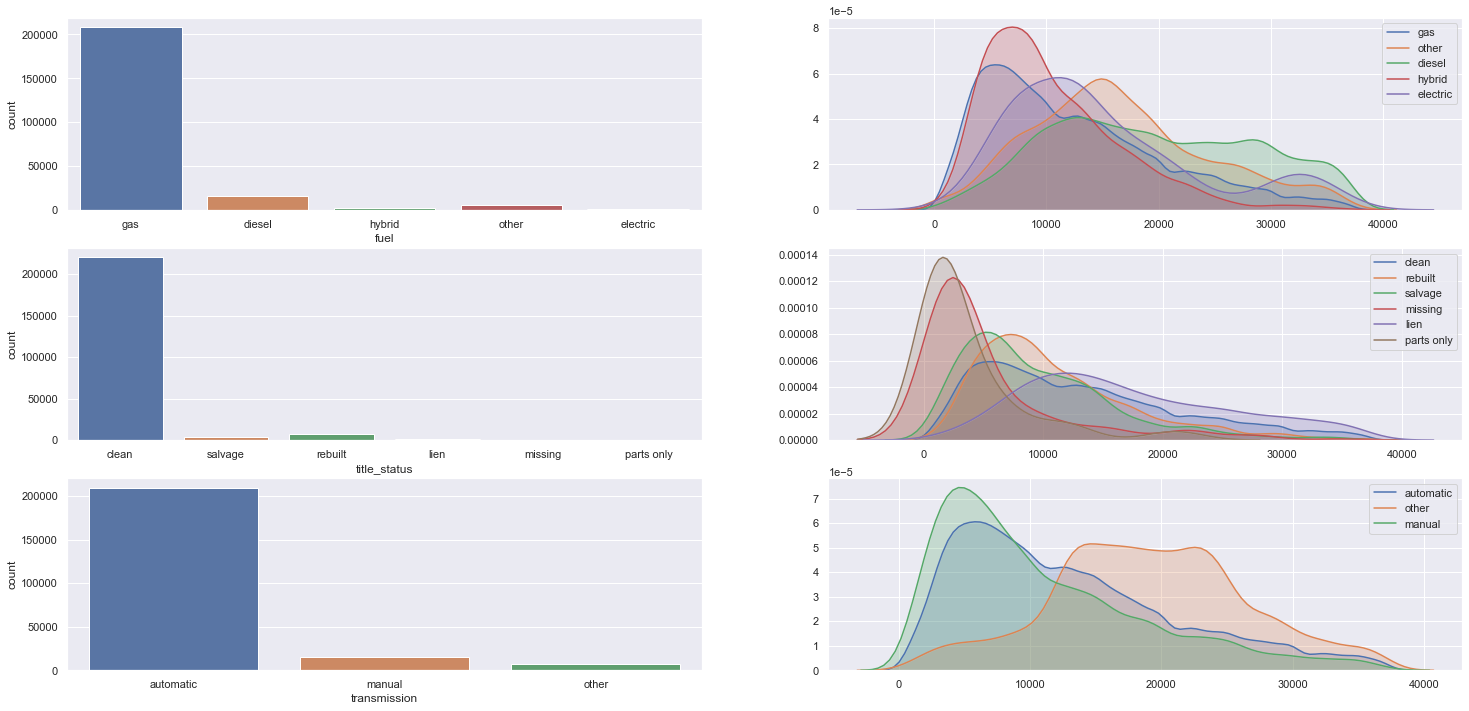

In [57]:
# fuel

plt.subplot( 3, 2, 1)
sns.countplot( df4['fuel'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['fuel'] == 'gas']['price'], label='gas', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'diesel']['price'], label='diesel', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'hybrid']['price'], label='hybrid', shade=True )
sns.kdeplot( df4[df4['fuel'] == 'electric']['price'], label='electric', shade=True )

# title_status

plt.subplot( 3, 2, 3)
sns.countplot( df4['title_status'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['title_status'] == 'clean']['price'], label='clean', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'rebuilt']['price'], label='rebuilt', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'salvage']['price'], label='salvage', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'missing']['price'], label='missing', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'lien']['price'], label='lien', shade=True )
sns.kdeplot( df4[df4['title_status'] == 'parts only']['price'], label='parts only', shade=True )

# transmission

plt.subplot( 3, 2, 5)
sns.countplot( df4['transmission'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['transmission'] == 'automatic']['price'], label='automatic', shade=True )
sns.kdeplot( df4[df4['transmission'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['transmission'] == 'manual']['price'], label='manual', shade=True )

<AxesSubplot:>

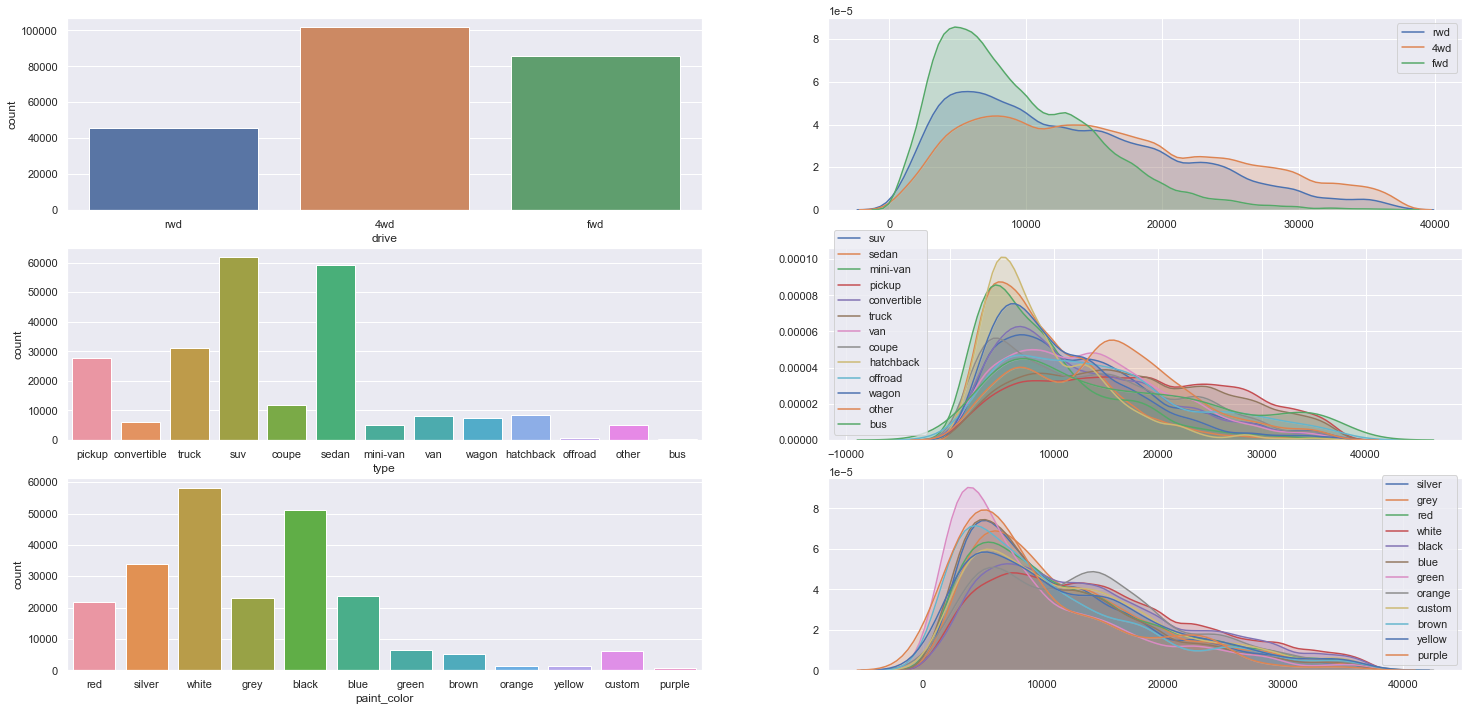

In [58]:
# drive

plt.subplot( 3, 2, 1)
sns.countplot( df4['drive'] )

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['drive'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['drive'] == 'rwd']['price'], label='rwd', shade=True )
sns.kdeplot( df4[df4['drive'] == '4wd']['price'], label='4wd', shade=True )
sns.kdeplot( df4[df4['drive'] == 'fwd']['price'], label='fwd', shade=True )

# type

plt.subplot( 3, 2, 3)
sns.countplot( df4['type'] )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['type'] == 'suv']['price'], label='suv', shade=True )
sns.kdeplot( df4[df4['type'] == 'sedan']['price'], label='sedan', shade=True )
sns.kdeplot( df4[df4['type'] == 'mini-van']['price'], label='mini-van', shade=True )
sns.kdeplot( df4[df4['type'] == 'pickup']['price'], label='pickup', shade=True )
sns.kdeplot( df4[df4['type'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['type'] == 'convertible']['price'], label='convertible', shade=True )
sns.kdeplot( df4[df4['type'] == 'truck']['price'], label='truck', shade=True )
sns.kdeplot( df4[df4['type'] == 'van']['price'], label='van', shade=True )
sns.kdeplot( df4[df4['type'] == 'coupe']['price'], label='coupe', shade=True )
sns.kdeplot( df4[df4['type'] == 'hatchback']['price'], label='hatchback', shade=True )
sns.kdeplot( df4[df4['type'] == 'offroad']['price'], label='offroad', shade=True )
sns.kdeplot( df4[df4['type'] == 'wagon']['price'], label='wagon', shade=True )
sns.kdeplot( df4[df4['type'] == 'other']['price'], label='other', shade=True )
sns.kdeplot( df4[df4['type'] == 'bus']['price'], label='bus', shade=True )

# paint_color

plt.subplot( 3, 2, 5)
sns.countplot( df4['paint_color'] )

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['paint_color'] == 'silver']['price'], label='silver', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'grey']['price'], label='grey', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'unknown']['price'], label='unknown', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'red']['price'], label='red', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'white']['price'], label='white', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'black']['price'], label='black', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'blue']['price'], label='blue', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'green']['price'], label='green', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'orange']['price'], label='orange', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'custom']['price'], label='custom', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'brown']['price'], label='brown', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'yellow']['price'], label='yellow', shade=True )
sns.kdeplot( df4[df4['paint_color'] == 'purple']['price'], label='purple', shade=True )

## 4.2 Bivariate Analysis

### **H1. Used cars with high Mailage should be cheaper.**
**TRUE** Used cars with high Mailage are cheaper.

<AxesSubplot:xlabel='odometer', ylabel='price'>

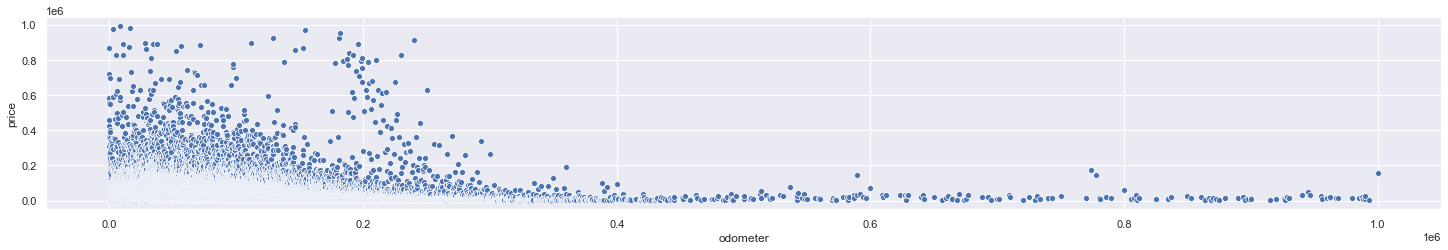

In [59]:
aux1 = df4[['odometer', 'price']].groupby( 'odometer' ).sum().reset_index()
plt.subplot(3,1,1)
sns.scatterplot( x=aux1[aux1['odometer']<1000000]['odometer'], y=aux1[aux1['price']<1000000]['price'], data=aux1)

# As the odometer values at first have outliers, I made a cut so that we can take a closer look at how the odometer behaves in relation to the sale price of the cars.
# Here we can already see how the price goes down while the odometer's value goes up.

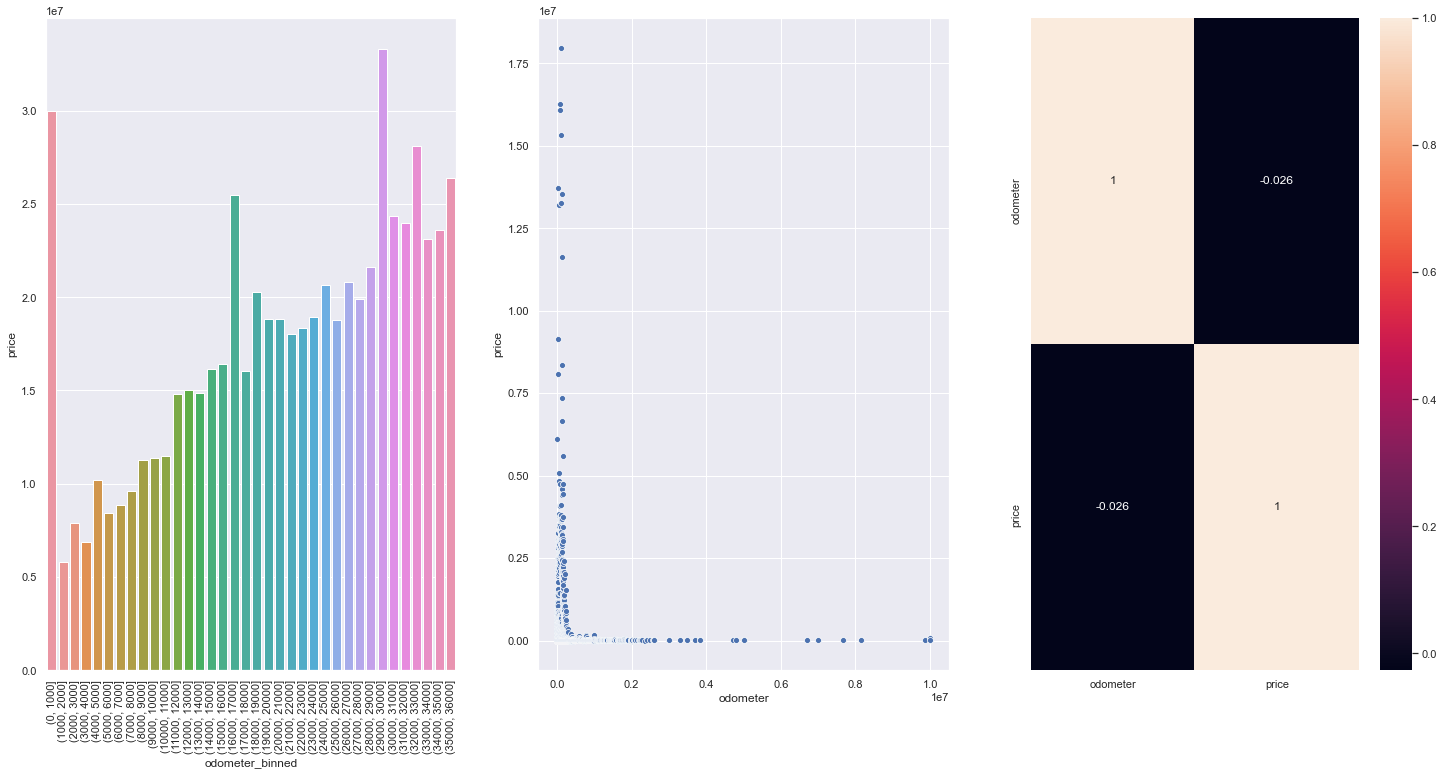

In [60]:
plt.subplot(1,3,1)
bins = list( np.arange(0, 37000, 1000) )
aux1['odometer_binned'] = pd.cut( aux1['odometer'], bins=bins )
aux2 = aux1[['odometer_binned', 'price']].groupby( 'odometer_binned' ).sum().reset_index()
sns.barplot( x='odometer_binned', y='price', data=aux2)
plt.xticks( rotation=90)

plt.subplot(1,3,2)
sns.scatterplot( x='odometer', y='price', data=aux1 )

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# As the odometer values are continuous numbers, to better visualize I arranged their values in bins.
# Looking at these three graphs, it became clear that the price of cars goes down while the odometer goes up.
# Looking at the heatmap we see that the influence on the price is very small anyway.

### **H2. Used cars with better appearance should be expensive.**
**TRUE** Used cars with better appearance are expensive.

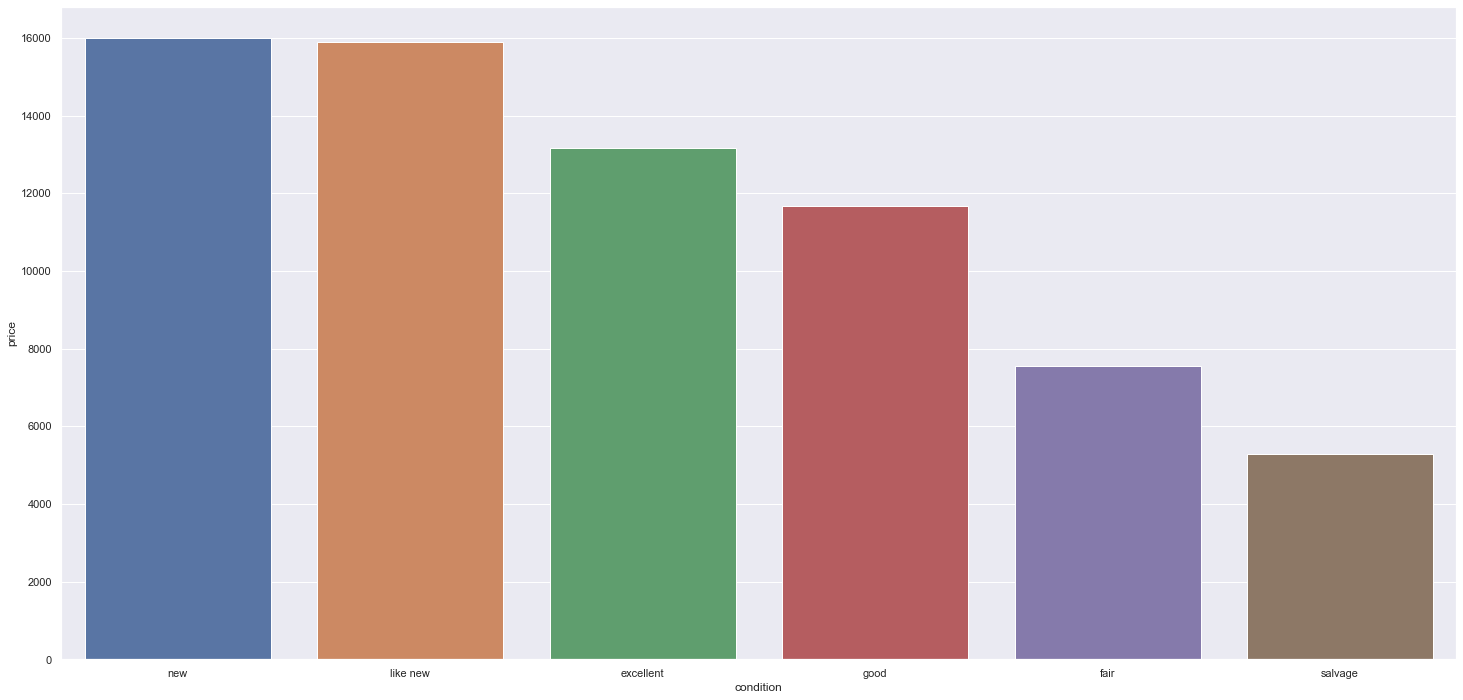

In [61]:
aux1 = df4[['condition', 'price']].groupby( 'condition' ).mean().reset_index()
sns.barplot( x='condition', y='price', data=aux1, order=['new', 'like new', 'excellent', 'good', 'fair', 'salvage']);

# Adjusting the order of the condition of the cars from the best condition to the worst condition, we see a drop in price as the condition of the car worsens.

### **H3. Used cars in west or northeast regions should cost more.**
**FALSE** Used cars in west or northeast regions aren't cost more.

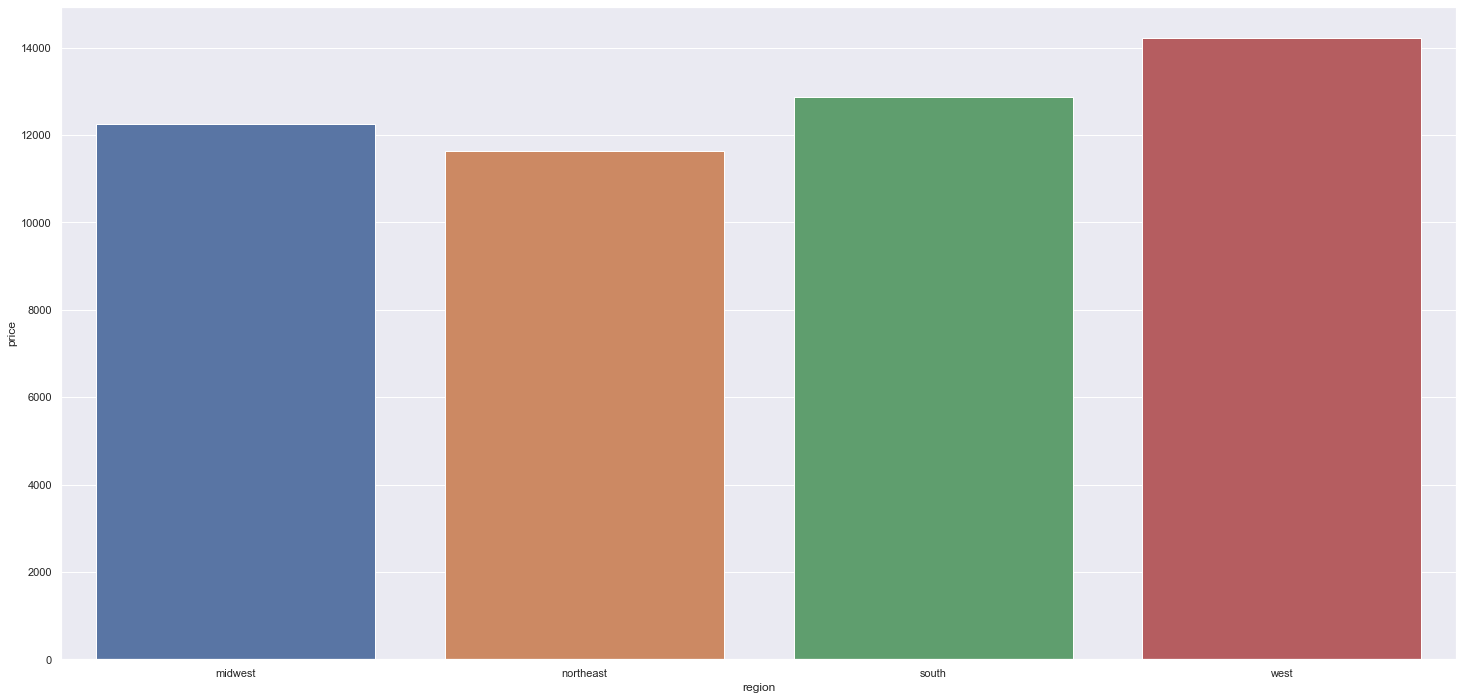

In [62]:
aux1 = df4[['region', 'price']].groupby( 'region' ).mean().reset_index()
sns.barplot( x='region', y='price', data=aux1);

# Just "west" region cost more. The "northeast" cost less.

### **H4. Used cars in rich states should cost more.**
**FALSE** Used cars in rich states aren't cost more.

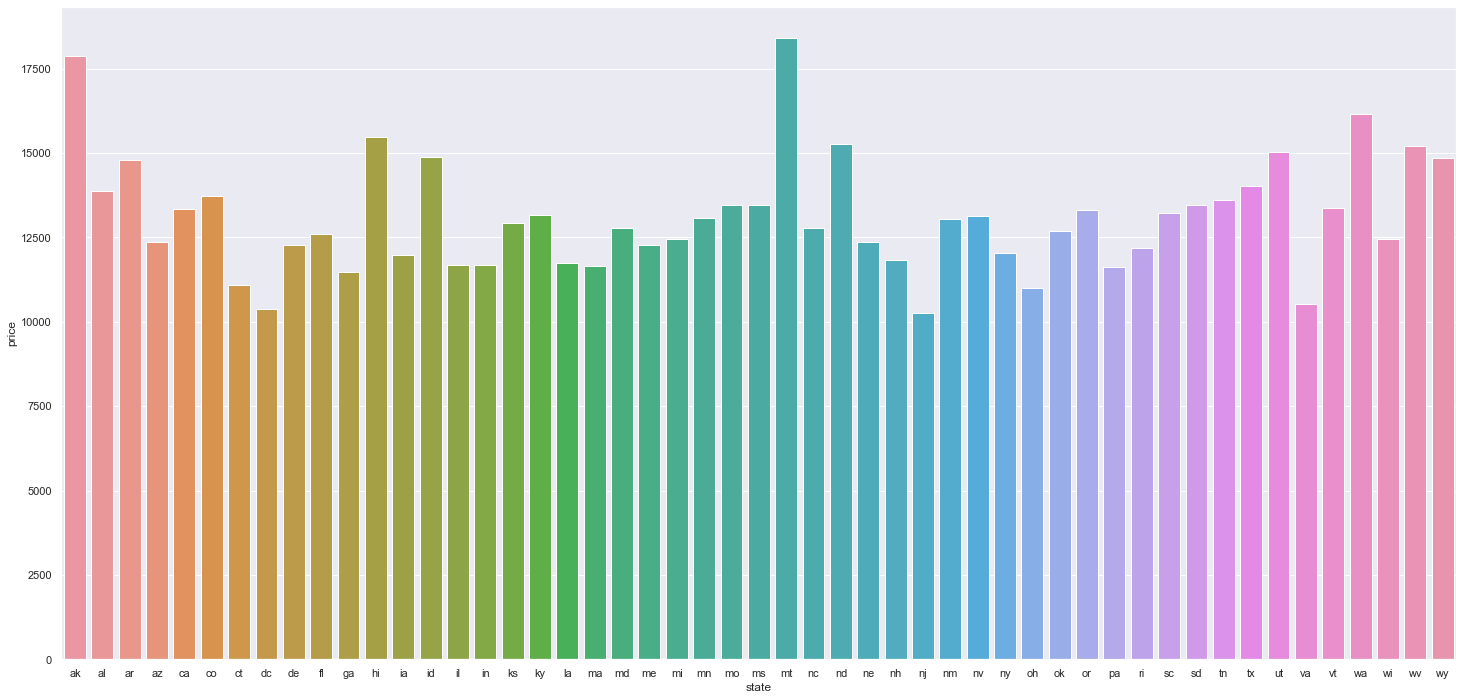

In [63]:
aux1 = df4[['state', 'price']].groupby( 'state' ).mean().reset_index()
sns.barplot( x='state', y='price', data=aux1);

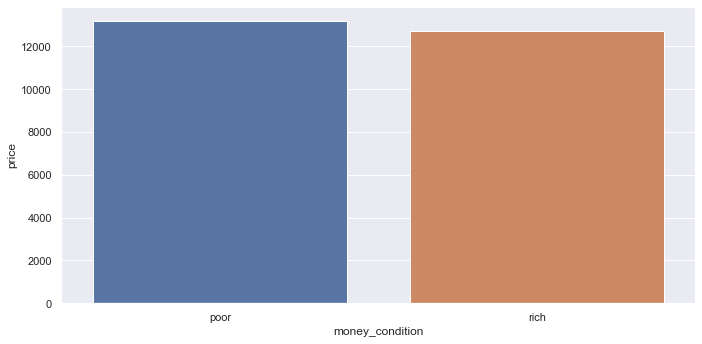

In [64]:
# To visualize better the difference between rich states and poor states I will separate them.
# The top 10 states richest:
# nh, hi, mn, ut, nk, md, ma, va, co, nj.
aux1['money_condition'] = aux1['state'].apply( lambda x: 'rich' if x == 'nh' or x == 'hi' or x == 'mn' or x == 'ut' or x == 'nk' or x == 'md' or x == 'ma' or x == 'va' or x == 'co' or x == 'nj' else 'poor' )
aux2 = aux1[['money_condition', 'price']].groupby( 'money_condition' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='money_condition', y='price', data=aux2 );

### **H5. Used cars which come from big manufacturer should be cost more.**
**TRUE** Used cars which come from big manufacturer cost more.

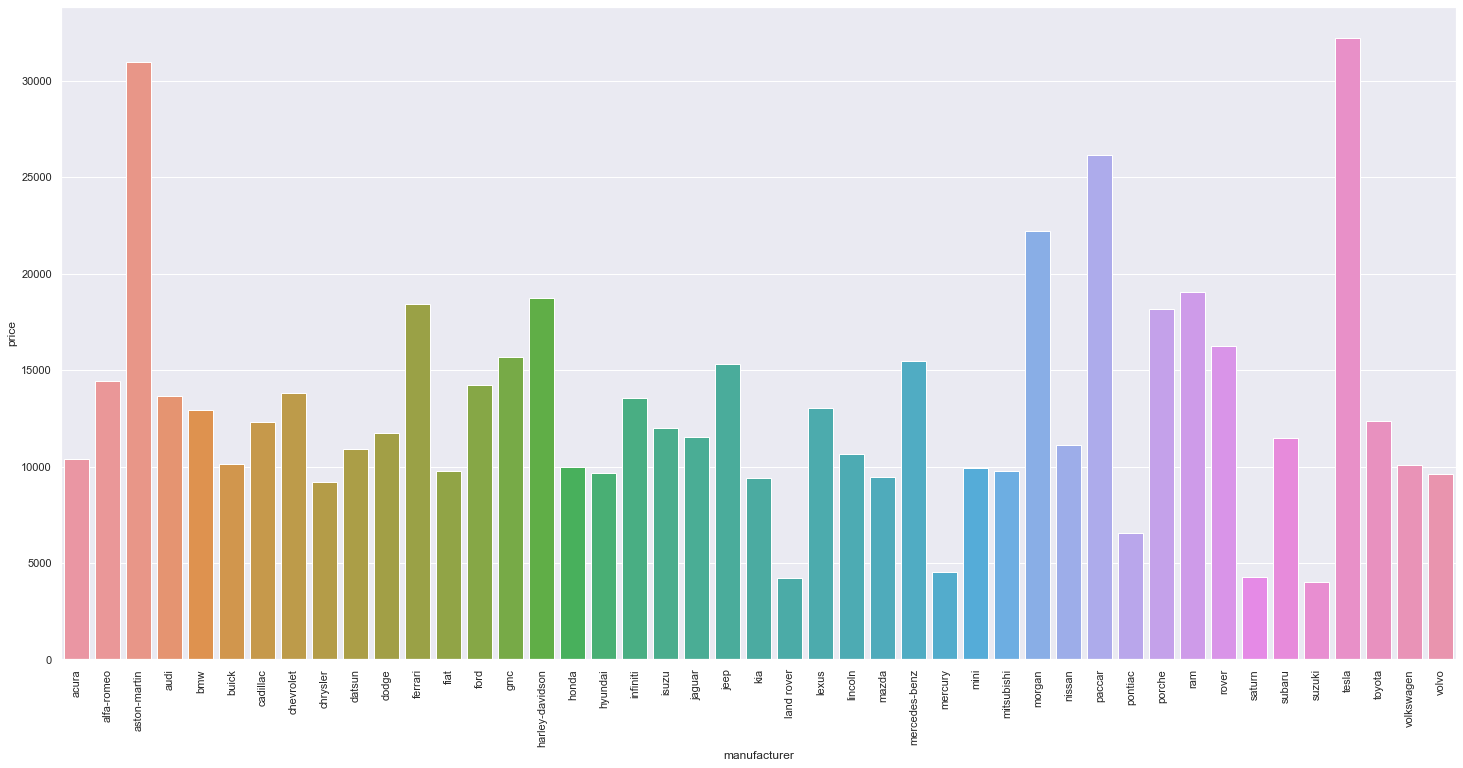

In [65]:
aux1 = df4[['manufacturer', 'price']].groupby( 'manufacturer' ).mean().reset_index()
sns.barplot( x='manufacturer', y='price', data=aux1);
plt.xticks( rotation=90);

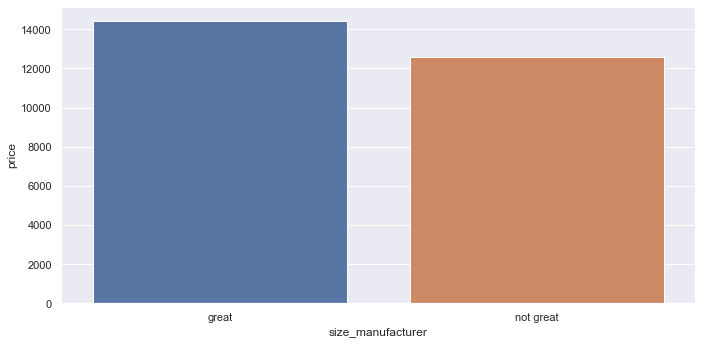

In [66]:
# To visualize better the difference between great manufacturer and not so great manufacturer I will separate them.
# The top manufacturer are:
# toyota, gmc, chevrolet, volkswagen, ford, bmw, nissan, hyundai, honda, mercedes-benz, jaguar, ferrari and tesla
aux1['size_manufacturer'] = aux1['manufacturer'].apply( lambda x: 'great' if x == 'toyota' or x == 'gmc' or x == 'chevrolet' or x == 'volkswagen' or x == 'ford' or x == 'bmw' or x == 'nissan' or x == 'hyundai' or x == 'honda' or x == 'mercedes-benz' or x == 'jaguar' or x == 'ferrari' or x == 'tesla' else 'not great' )
aux2 = aux1[['size_manufacturer', 'price']].groupby( 'size_manufacturer' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='size_manufacturer', y='price', data=aux2 );

### **H6. Used cars with 4wd drive should be cost more.**
**TRUE** Used cars with 4wd drive should cost more.


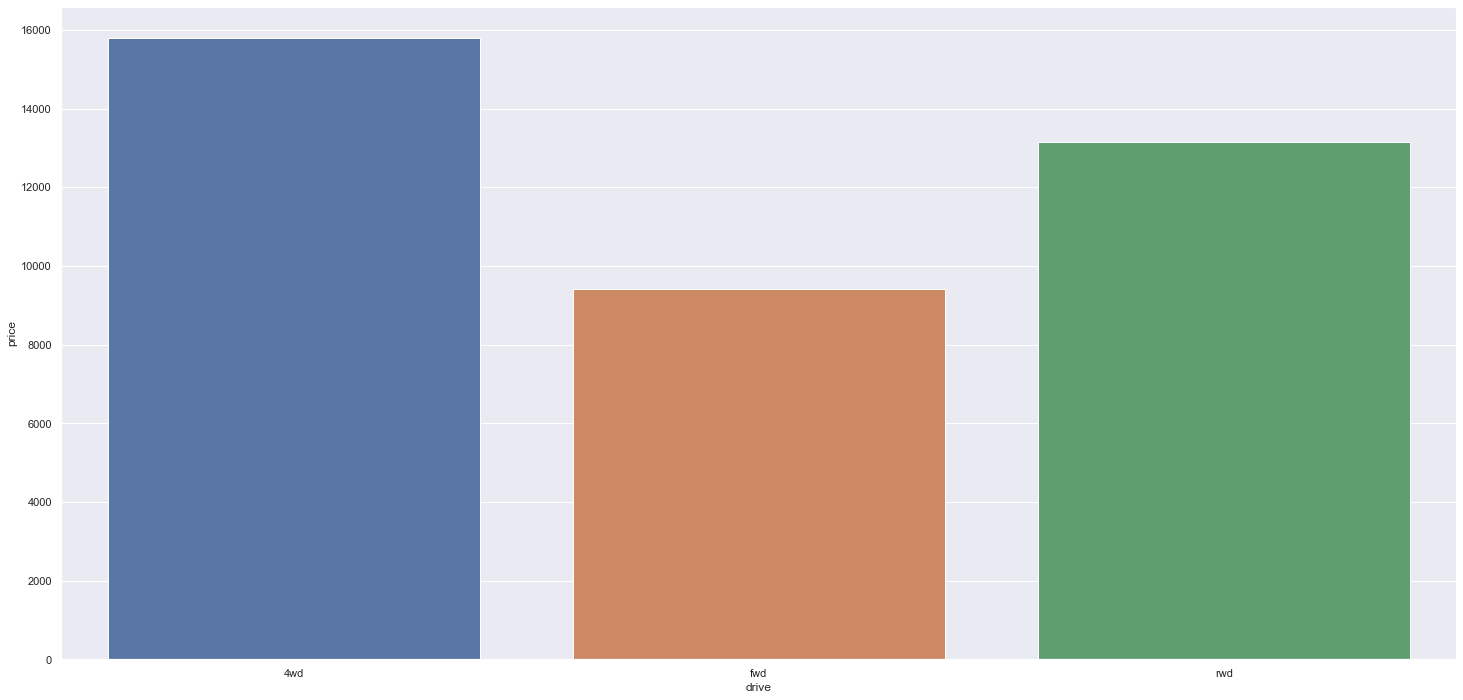

In [67]:
aux1 = df4[['drive', 'price']].groupby( 'drive' ).mean().reset_index()
sns.barplot( x='drive', y='price', data=aux1);

### **H7. Used cars with electric fuel should be expensive.**
**FALSE** Used cars with electric fuel aren't expensive.

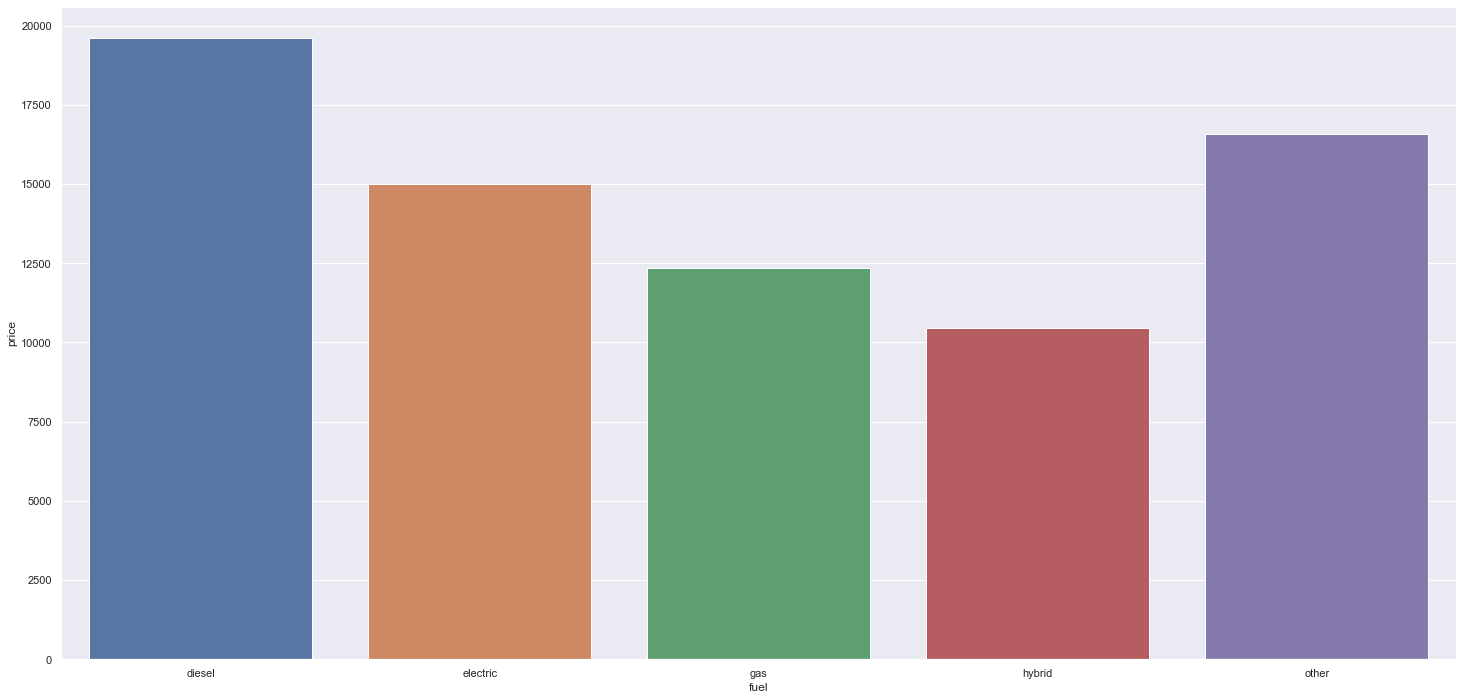

In [68]:
aux1 = df4[['fuel', 'price']].groupby( 'fuel' ).mean().reset_index()
sns.barplot( x='fuel', y='price', data=aux1);

### **H8. Used cars with SUV, pickup or truck type should cost more.**
**TRUE** Used cars with SUV, pickup or truck type cost more.



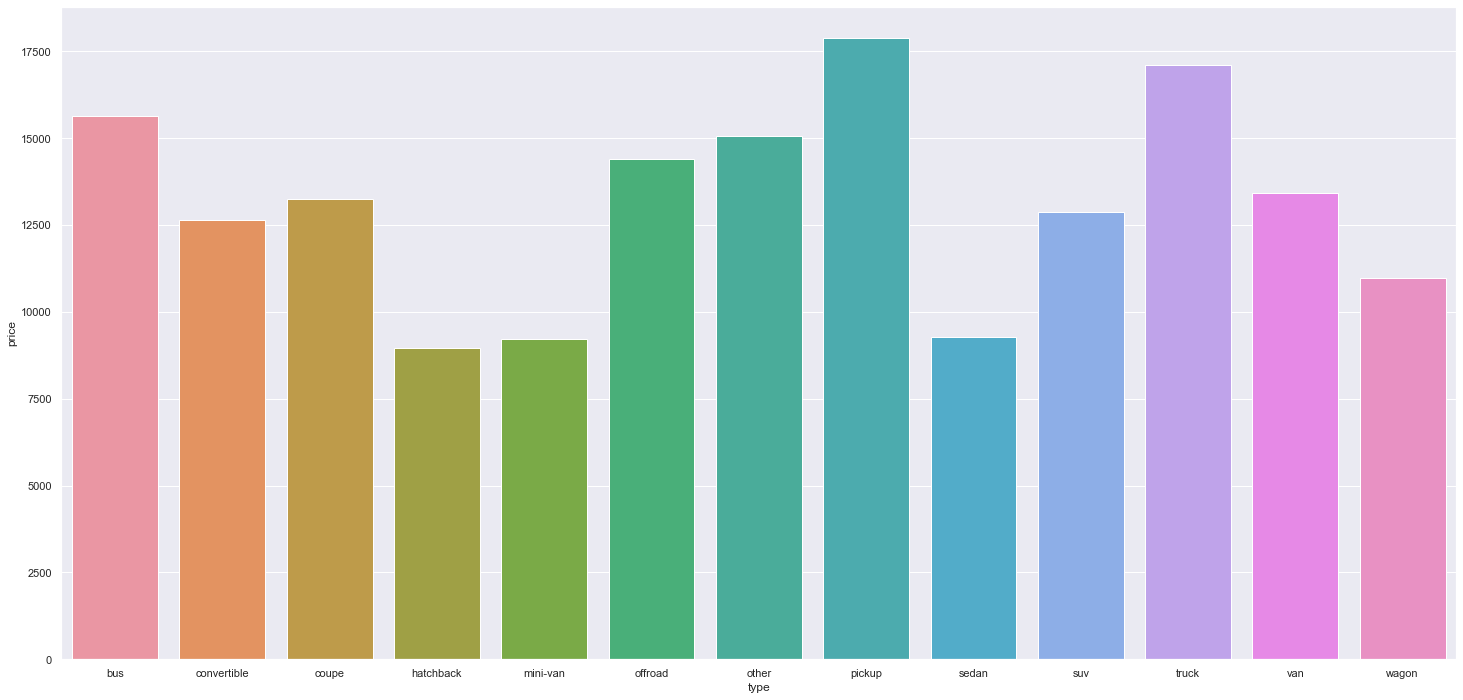

In [69]:
aux1 = df4[['type', 'price']].groupby( 'type' ).mean().reset_index()
sns.barplot( x='type', y='price', data=aux1);

### **H9. Used cars with automatic transmission should be cost more.**
**TRUE** Used cars with automatic transmission cost more.

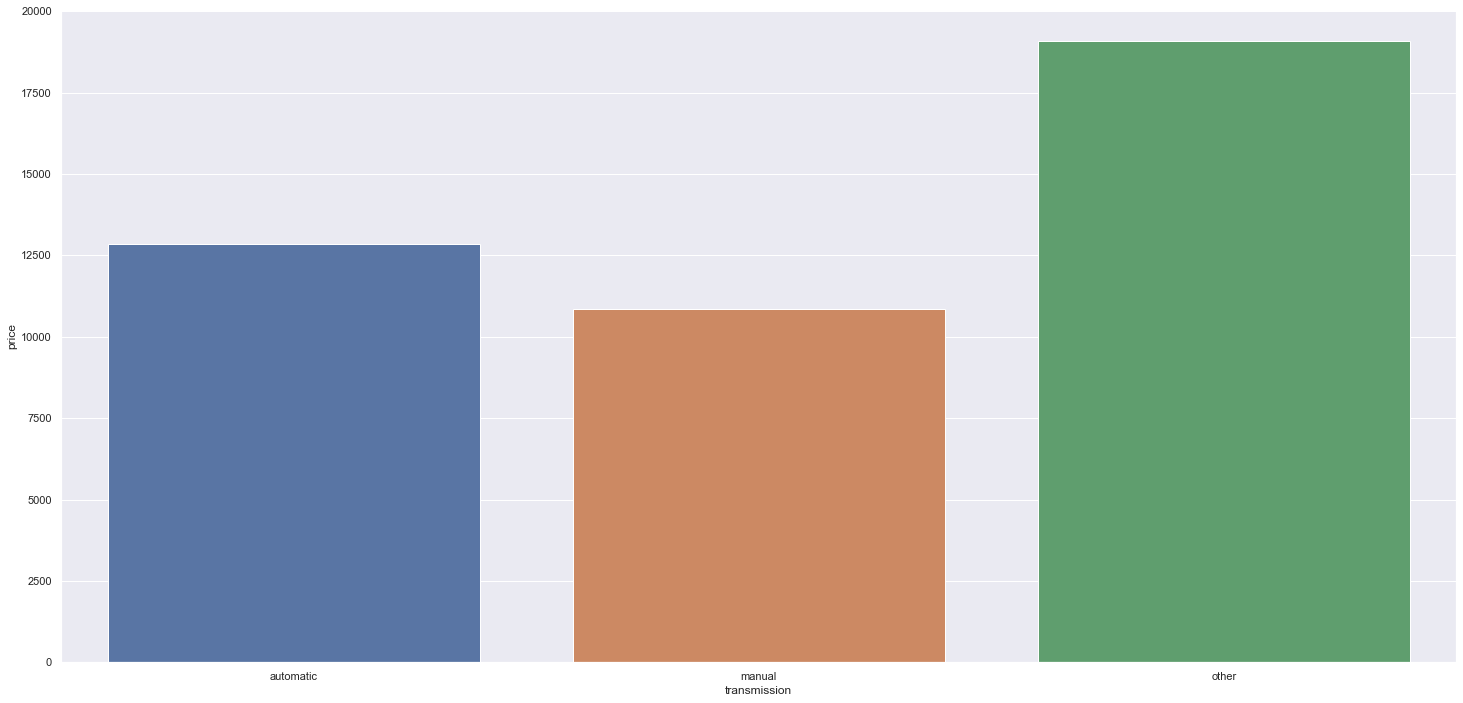

In [70]:
aux1 = df4[['transmission', 'price']].groupby( 'transmission' ).mean().reset_index()
sns.barplot( x='transmission', y='price', data=aux1);

### **H10. Used cars with silver or black paint-color should be expensive.**
**FALSE** Used cars with silver or black paint-color aren't expensive.

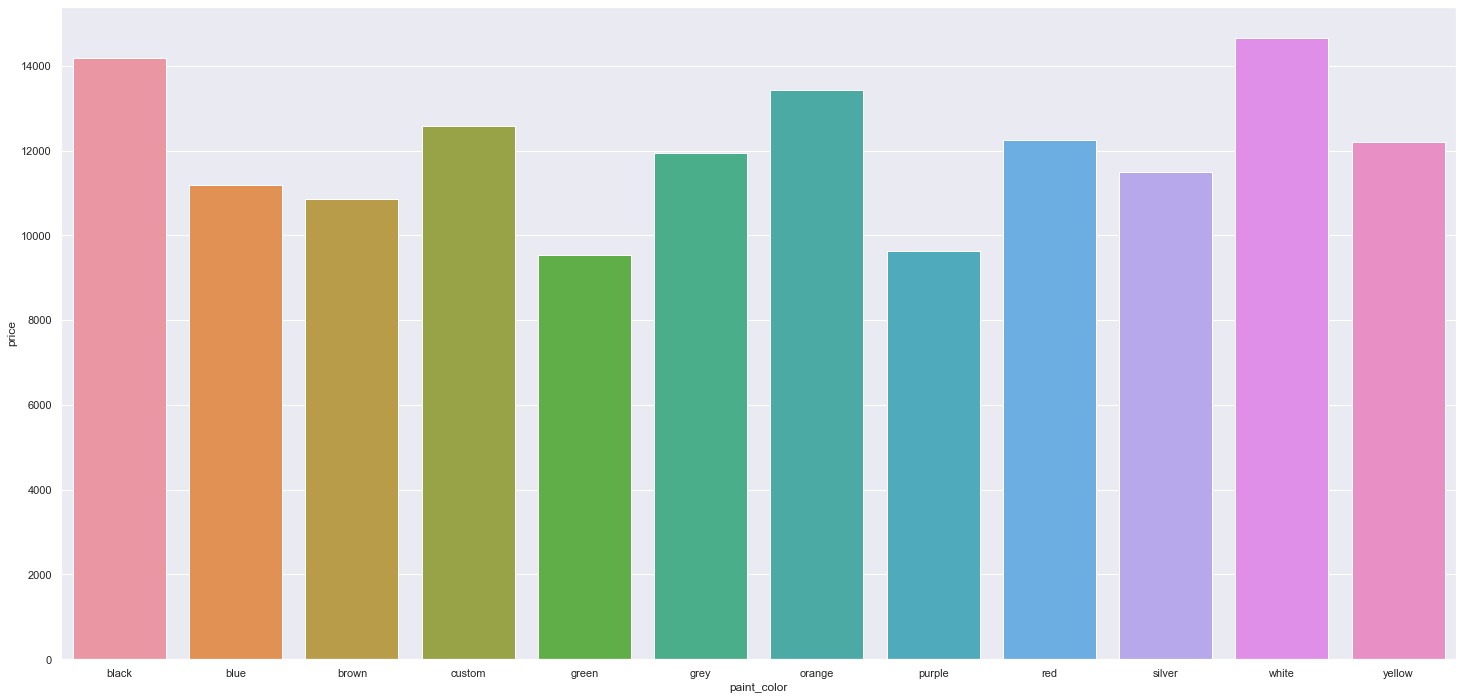

In [71]:
aux1 = df4[['paint_color', 'price']].groupby( 'paint_color' ).mean().reset_index()
sns.barplot( x='paint_color', y='price', data=aux1);

### **H11. Used cars with more cylinders should be expensive.**
**TRUE** Used cars with more cylinders are expensive.

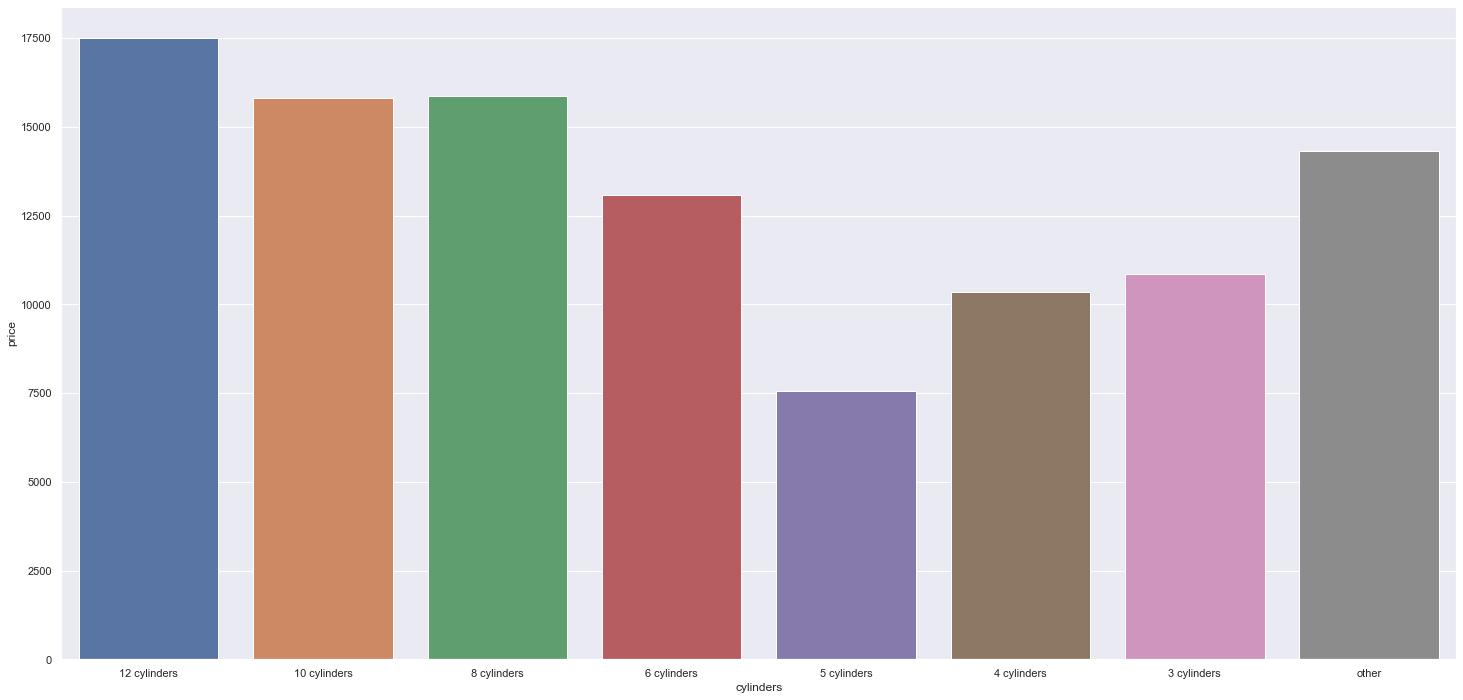

In [72]:
aux1 = df4[['cylinders', 'price']].groupby( 'cylinders' ).mean().reset_index()
sns.barplot( x='cylinders', y='price', data=aux1, order=['12 cylinders', '10 cylinders', '8 cylinders', '6 cylinders', '5 cylinders', '4 cylinders', '3 cylinders', 'other']);

### **H12. Used cars with Lat/Long loacated in cost areas should cost more.**
**FALSE** Used cars with Lat/Long loacated in cost areas should cost more.


In [73]:
#df_shuffled = df4.sample(frac=1)
#df_shuffled.head()
#m = Basemap(projection='mill',
#            llcrnrlat = 25,
#            llcrnrlon = -170,
#            urcrnrlat = 80,
#            urcrnrlon = -60,
#            resolution='l')
#m.drawcoastlines()
#m.drawcountries(linewidth=2)
#m.drawstates(color='b')
#i = 0
#for index, row in df_shuffled.iterrows():
#    lat = row['lat']
#    lon = row['long']
#    price = row['price']
#    xpt, ypt = m(lon, lat)
#    m.plot(xpt,ypt,'.', markersize=0.2, c="red")
#    # stopping criteria
#    i = i + 1
#    if (i == 10000): break

### **H13. Used cars with less age should cost less.**
**TRUE** Used cars with less age cost less.

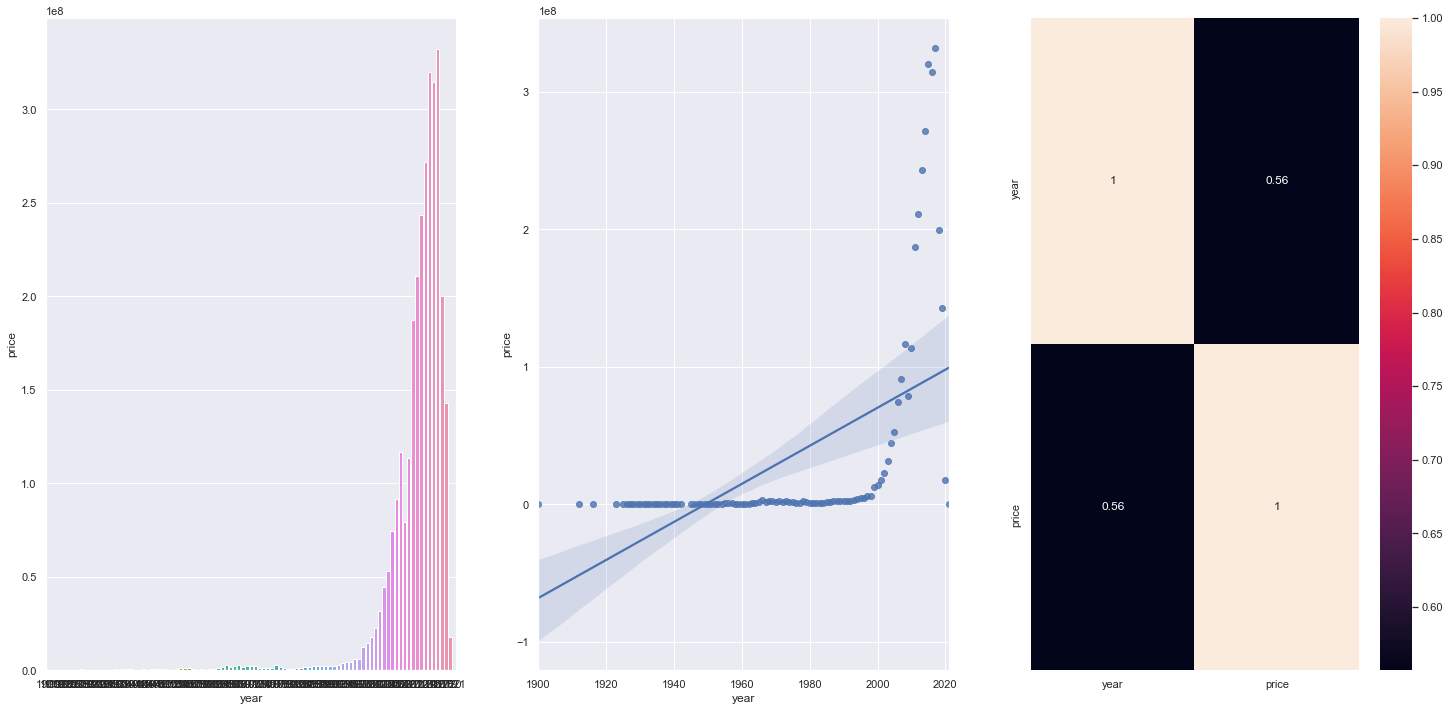

In [74]:
aux1 = df4[['year', 'price']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='price', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='price', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.1 Hypothesis Summary

In [75]:
tab = [['Hypoteses', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'True', 'High'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Medium'],
       ['H5', 'True', 'Medium'],
       ['H6', 'True', 'High'],
       ['H7', 'False', 'High'],
       ['H8', 'True', 'High'],
       ['H9', 'True', 'Medium'],
       ['H10', 'False', 'Low'],
       ['H11', 'True', 'High'],
       ['H12', 'False', 'Low'],
       ['H13', 'True', 'High']
      ]
print( tabulate( tab, headers='firstrow' ) )

Hypoteses    Conclusion    Relevance
-----------  ------------  -----------
H1           True          High
H2           True          High
H3           False         Medium
H4           False         Medium
H5           True          Medium
H6           True          High
H7           False         High
H8           True          High
H9           True          Medium
H10          False         Low
H11          True          High
H12          False         Low
H13          True          High


## 4.3 Multivariable Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

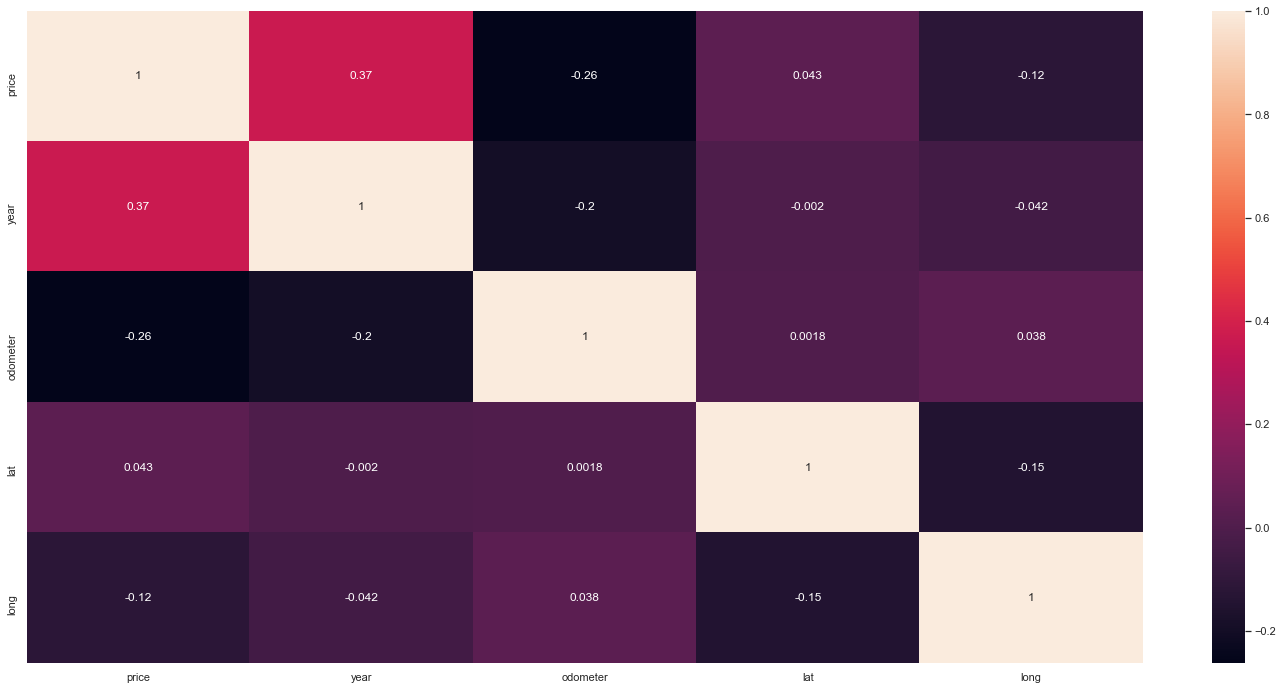

In [76]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

### 4.3.2 Categorical Attributes

<AxesSubplot:>

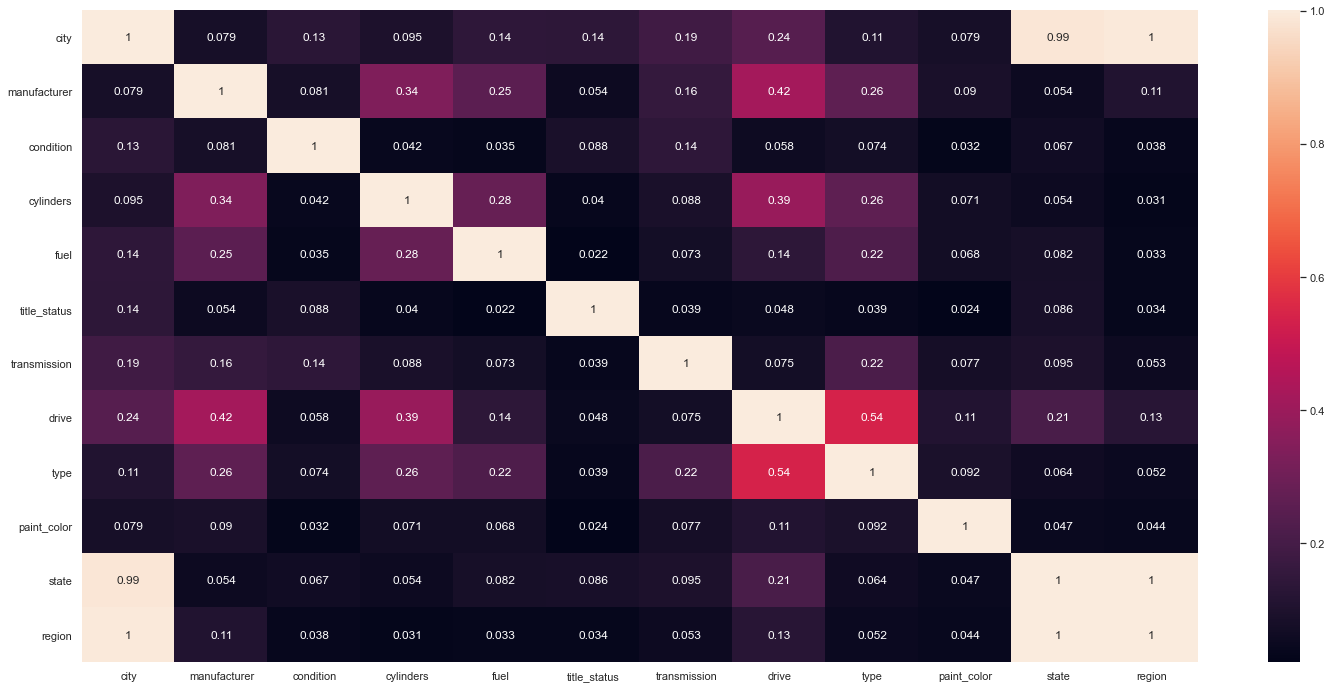

In [77]:
# Only categorical data
a = df4
a1 = cramer_v( a['city'], a['city'] )

# Calculate cramer V
a2 = cramer_v( a['city'], a['manufacturer'] )
a3 = cramer_v( a['city'], a['condition'] )
a4 = cramer_v( a['city'], a['cylinders'] )
a5 = cramer_v( a['city'], a['fuel'] )
a6 = cramer_v( a['city'], a['title_status'] )
a7 = cramer_v( a['city'], a['transmission'] )
a8 = cramer_v( a['city'], a['drive'] )
a9 = cramer_v( a['city'], a['type'] )
a10 = cramer_v( a['city'], a['paint_color'] )
a11 = cramer_v( a['city'], a['state'] )
a12 = cramer_v( a['city'], a['region'] )

a13 = cramer_v( a['manufacturer'], a['city'] )
a14 = cramer_v( a['manufacturer'], a['manufacturer'] )
a15 = cramer_v( a['manufacturer'], a['condition'] )
a16 = cramer_v( a['manufacturer'], a['cylinders'] )
a17 = cramer_v( a['manufacturer'], a['fuel'] )
a18 = cramer_v( a['manufacturer'], a['title_status'] )
a19 = cramer_v( a['manufacturer'], a['transmission'] )
a20 = cramer_v( a['manufacturer'], a['drive'] )
a21 = cramer_v( a['manufacturer'], a['type'] )
a22 = cramer_v( a['manufacturer'], a['paint_color'] )
a23 = cramer_v( a['manufacturer'], a['state'] )
a24 = cramer_v( a['manufacturer'], a['region'] )

a25 = cramer_v( a['condition'], a['city'] )
a26 = cramer_v( a['condition'], a['manufacturer'] )
a27 = cramer_v( a['condition'], a['condition'] )
a28 = cramer_v( a['condition'], a['cylinders'] )
a29 = cramer_v( a['condition'], a['fuel'] )
a30 = cramer_v( a['condition'], a['title_status'] )
a31 = cramer_v( a['condition'], a['transmission'] )
a32 = cramer_v( a['condition'], a['drive'] )
a33 = cramer_v( a['condition'], a['type'] )
a34 = cramer_v( a['condition'], a['paint_color'] )
a35 = cramer_v( a['condition'], a['state'] )
a36 = cramer_v( a['condition'], a['region'] )

a37 = cramer_v( a['cylinders'], a['city'] )
a38 = cramer_v( a['cylinders'], a['manufacturer'] )
a39 = cramer_v( a['cylinders'], a['condition'] )
a40 = cramer_v( a['cylinders'], a['cylinders'] )
a41 = cramer_v( a['cylinders'], a['fuel'] )
a42 = cramer_v( a['cylinders'], a['title_status'] )
a43 = cramer_v( a['cylinders'], a['transmission'] )
a44 = cramer_v( a['cylinders'], a['drive'] )
a45 = cramer_v( a['cylinders'], a['type'] )
a46 = cramer_v( a['cylinders'], a['paint_color'] )
a47 = cramer_v( a['cylinders'], a['state'] )
a48 = cramer_v( a['cylinders'], a['region'] )

a49 = cramer_v( a['fuel'], a['city'] )
a50 = cramer_v( a['fuel'], a['manufacturer'] )
a51 = cramer_v( a['fuel'], a['condition'] )
a52 = cramer_v( a['fuel'], a['cylinders'] )
a53 = cramer_v( a['fuel'], a['fuel'] )
a54 = cramer_v( a['fuel'], a['title_status'] )
a55 = cramer_v( a['fuel'], a['transmission'] )
a56 = cramer_v( a['fuel'], a['drive'] )
a57 = cramer_v( a['fuel'], a['type'] )
a58 = cramer_v( a['fuel'], a['paint_color'] )
a59 = cramer_v( a['fuel'], a['state'] )
a60 = cramer_v( a['fuel'], a['region'] )

a61 = cramer_v( a['title_status'], a['city'] )
a62 = cramer_v( a['title_status'], a['manufacturer'] )
a63 = cramer_v( a['title_status'], a['condition'] )
a64 = cramer_v( a['title_status'], a['cylinders'] )
a65 = cramer_v( a['title_status'], a['fuel'] )
a66 = cramer_v( a['title_status'], a['title_status'] )
a67 = cramer_v( a['title_status'], a['transmission'] )
a68 = cramer_v( a['title_status'], a['drive'] )
a69 = cramer_v( a['title_status'], a['type'] )
a70 = cramer_v( a['title_status'], a['paint_color'] )
a71 = cramer_v( a['title_status'], a['state'] )
a72 = cramer_v( a['title_status'], a['region'] )

a73 = cramer_v( a['transmission'], a['city'] )
a74 = cramer_v( a['transmission'], a['manufacturer'] )
a75 = cramer_v( a['transmission'], a['condition'] )
a76 = cramer_v( a['transmission'], a['cylinders'] )
a77 = cramer_v( a['transmission'], a['fuel'] )
a78 = cramer_v( a['transmission'], a['title_status'] )
a79 = cramer_v( a['transmission'], a['transmission'] )
a80 = cramer_v( a['transmission'], a['drive'] )
a81 = cramer_v( a['transmission'], a['type'] )
a82 = cramer_v( a['transmission'], a['paint_color'] )
a83 = cramer_v( a['transmission'], a['state'] )
a84 = cramer_v( a['transmission'], a['region'] )

a85 = cramer_v( a['drive'], a['city'] )
a86 = cramer_v( a['drive'], a['manufacturer'] )
a87 = cramer_v( a['drive'], a['condition'] )
a88 = cramer_v( a['drive'], a['cylinders'] )
a89 = cramer_v( a['drive'], a['fuel'] )
a90 = cramer_v( a['drive'], a['title_status'] )
a91 = cramer_v( a['drive'], a['transmission'] )
a92 = cramer_v( a['drive'], a['drive'] )
a93 = cramer_v( a['drive'], a['type'] )
a94 = cramer_v( a['drive'], a['paint_color'] )
a95 = cramer_v( a['drive'], a['state'] )
a96 = cramer_v( a['drive'], a['region'] )

a97 = cramer_v( a['type'], a['city'] )
a98 = cramer_v( a['type'], a['manufacturer'] )
a99 = cramer_v( a['type'], a['condition'] )
a100 = cramer_v( a['type'], a['cylinders'] )
a101 = cramer_v( a['type'], a['fuel'] )
a102 = cramer_v( a['type'], a['title_status'] )
a103 = cramer_v( a['type'], a['transmission'] )
a104 = cramer_v( a['type'], a['drive'] )
a105 = cramer_v( a['type'], a['type'] )
a106 = cramer_v( a['type'], a['paint_color'] )
a107 = cramer_v( a['type'], a['state'] )
a108 = cramer_v( a['type'], a['region'] )

a109 = cramer_v( a['paint_color'], a['city'] )
a110 = cramer_v( a['paint_color'], a['manufacturer'] )
a111 = cramer_v( a['paint_color'], a['condition'] )
a112 = cramer_v( a['paint_color'], a['cylinders'] )
a113 = cramer_v( a['paint_color'], a['fuel'] )
a114 = cramer_v( a['paint_color'], a['title_status'] )
a115 = cramer_v( a['paint_color'], a['transmission'] )
a116 = cramer_v( a['paint_color'], a['drive'] )
a117 = cramer_v( a['paint_color'], a['type'] )
a118 = cramer_v( a['paint_color'], a['paint_color'] )
a119 = cramer_v( a['paint_color'], a['state'] )
a120 = cramer_v( a['paint_color'], a['region'] )

a121 = cramer_v( a['state'], a['city'] )
a122= cramer_v( a['state'], a['manufacturer'] )
a123 = cramer_v( a['state'], a['condition'] )
a124 = cramer_v( a['state'], a['cylinders'] )
a125 = cramer_v( a['state'], a['fuel'] )
a126 = cramer_v( a['state'], a['title_status'] )
a127 = cramer_v( a['state'], a['transmission'] )
a128 = cramer_v( a['state'], a['drive'] )
a129 = cramer_v( a['state'], a['type'] )
a130 = cramer_v( a['state'], a['paint_color'] )
a131 = cramer_v( a['state'], a['state'] )
a132 = cramer_v( a['state'], a['region'] )

a133 = cramer_v( a['region'], a['city'] )
a134 = cramer_v( a['region'], a['manufacturer'] )
a135 = cramer_v( a['region'], a['condition'] )
a136 = cramer_v( a['region'], a['cylinders'] )
a137 = cramer_v( a['region'], a['fuel'] )
a138 = cramer_v( a['region'], a['title_status'] )
a139 = cramer_v( a['region'], a['transmission'] )
a140 = cramer_v( a['region'], a['drive'] )
a141 = cramer_v( a['region'], a['type'] )
a142 = cramer_v( a['region'], a['paint_color'] )
a143 = cramer_v( a['region'], a['state'] )
a144 = cramer_v( a['region'], a['region'] )

# Final dataset
d = pd.DataFrame( {'city':     [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12],
               'manufacturer': [a13, a14, a15, a16, a17, a18, a19, a20, a21, a22, a23, a24],
               'condition':    [a25, a26, a27, a28, a29, a30, a31, a32, a33, a34, a35, a36],
               'cylinders':    [a37, a38, a39, a40, a41, a42, a43, a44, a45, a46, a47, a48],
               'fuel':         [a49, a50, a51, a52, a53, a54, a55, a56, a57, a58, a59, a60],
               'title_status': [a61, a62, a63, a64, a65, a66, a67, a68, a69, a70, a71, a72],
               'transmission': [a73, a74, a75, a76, a77, a78, a79, a80, a81, a82, a83, a84],
               'drive':        [a85, a86, a87, a88, a89, a90, a91, a92, a93, a94, a95, a96],
               'type':         [a97, a98, a99, a100, a101, a102, a103, a104, a105, a106, a107, a108],
               'paint_color':  [a109, a110, a111, a112, a113, a114, a115, a116, a117, a118, a119, a120],
               'state':        [a121, a122, a123, a124, a125, a126, a127, a128, a129, a130, a131, a132],
               'region':       [a133, a134, a135, a136, a137, a138, a139, a140, a141, a142, a143, a144]} )

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 STEP 05 - DATA PREPARATION

In [78]:
df5 = df4.copy()

## 5.1 Normalization

In [79]:
# We don't have any data distribution like a Gaussian.

## 5.2 Rescaling

In [80]:
a = df5.select_dtypes( include=['int64', 'float64'] )

<AxesSubplot:xlabel='year'>

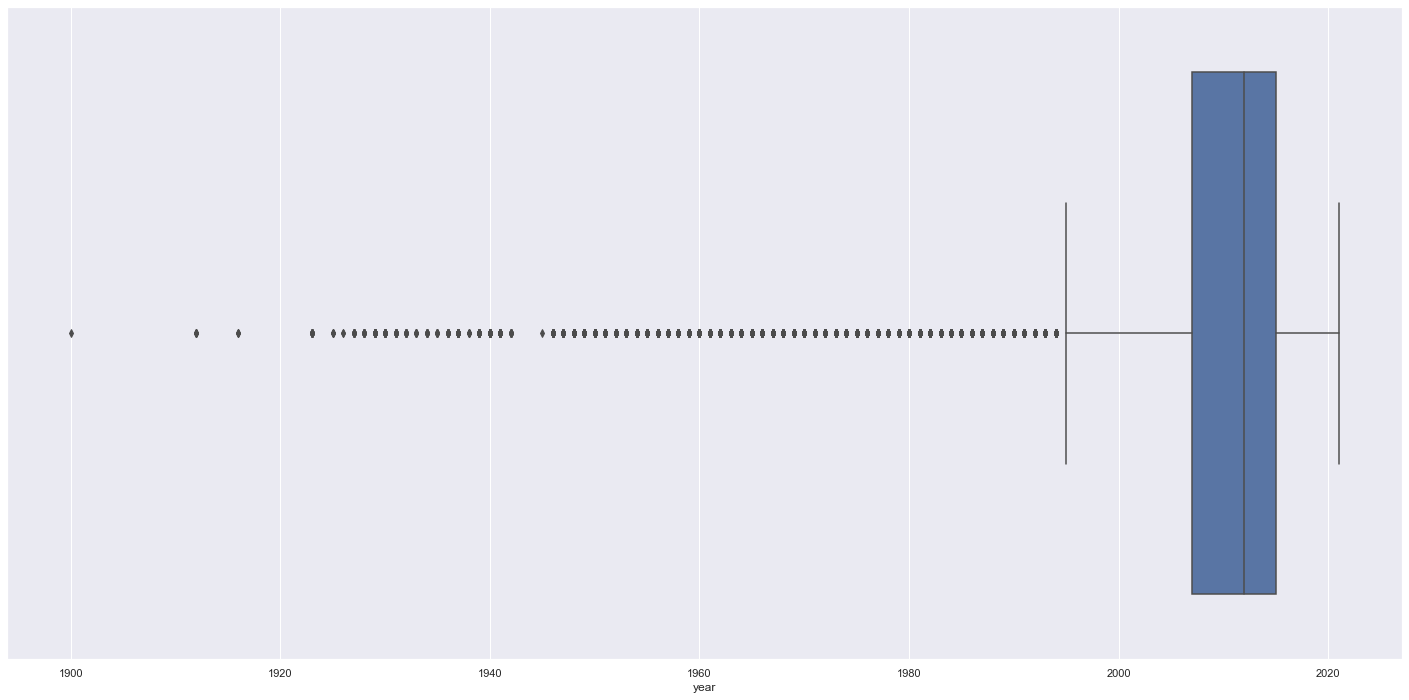

In [81]:
sns.boxplot( df5['year'] )

<AxesSubplot:xlabel='odometer'>

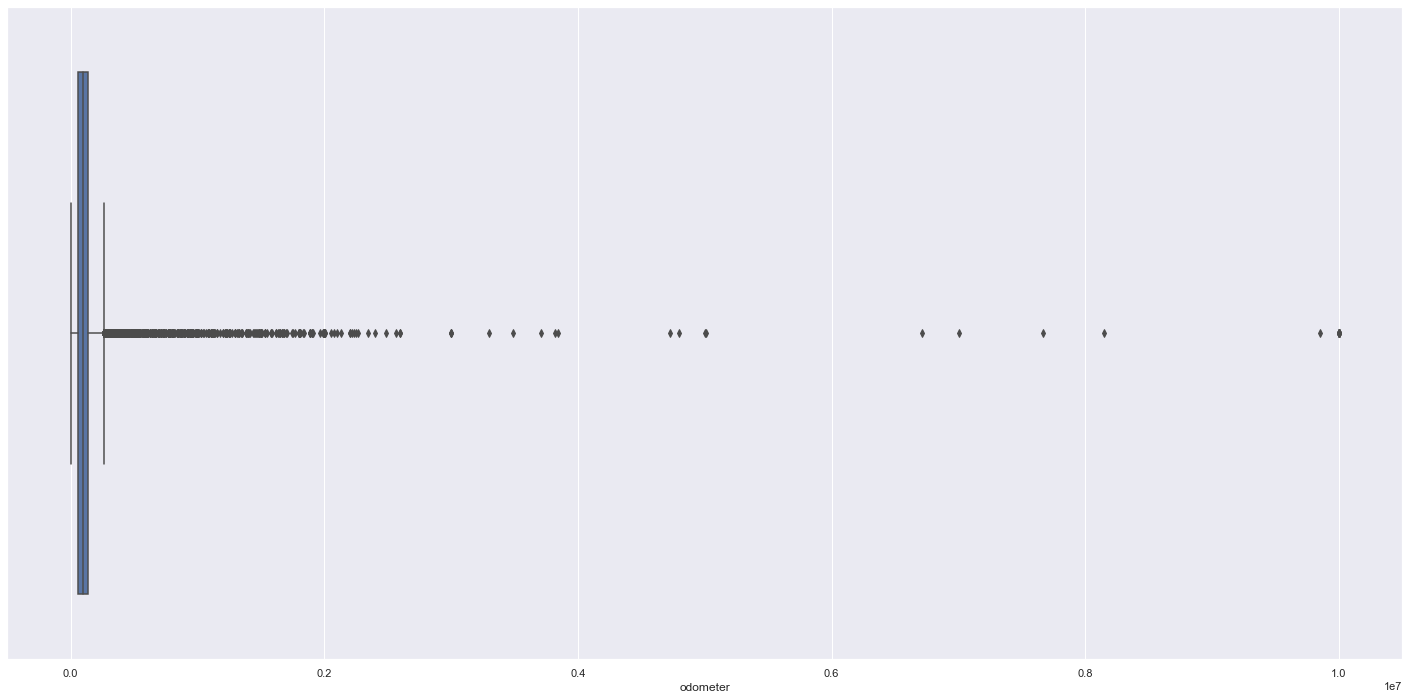

In [82]:
sns.boxplot( df5['odometer'] )

<AxesSubplot:xlabel='lat'>

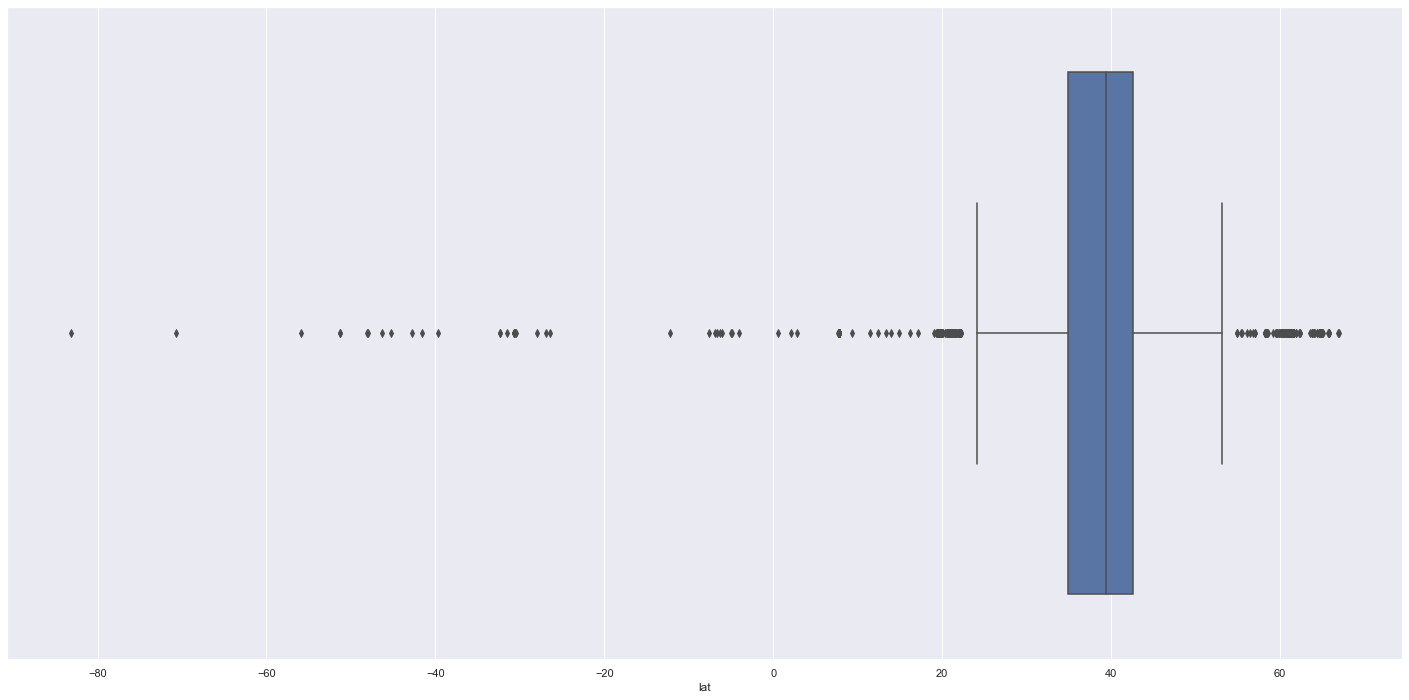

In [83]:
sns.boxplot( df5['lat'] )

<AxesSubplot:xlabel='long'>

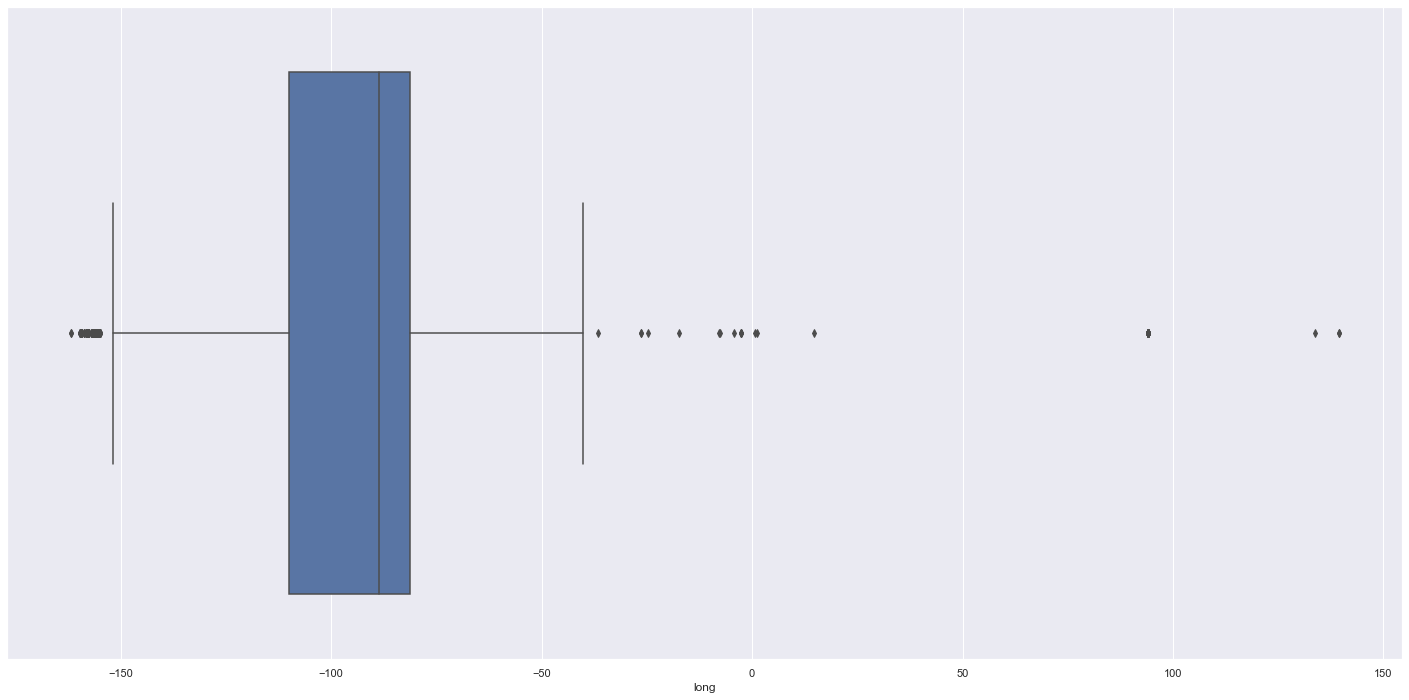

In [84]:
sns.boxplot( df5['long'] )

In [85]:
rs = RobustScaler()

# year
df5['year'] = rs.fit_transform( df5[['year']].values )

# odometer
df5['odometer'] = rs.fit_transform( df5[['odometer']].values )

# lat
df5['lat'] = rs.fit_transform( df5[['lat']].values )

# long
df5['long'] = rs.fit_transform( df5[['long']].values )

<AxesSubplot:xlabel='year'>

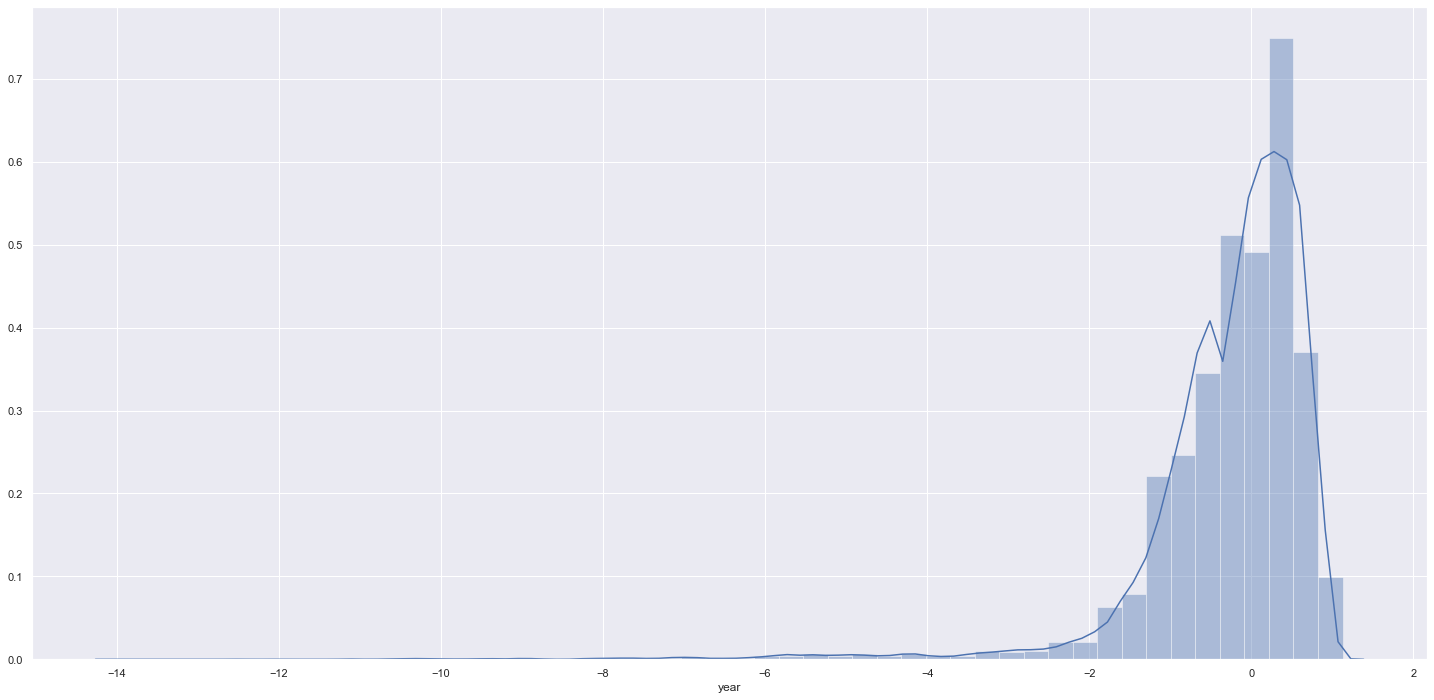

In [86]:
sns.distplot( df5['year'] )

## 5.3 Transformation

### 5.3.1 Encoding

In [87]:
# Below I will transform the variables with little different values. Because of it we don't problem with create new columns.
# fuel, transmission, drive - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['fuel'], columns=['fuel'] )
df5 = pd.get_dummies( df5, prefix=['transmission'], columns=['transmission'] )
df5 = pd.get_dummies( df5, prefix=['drive'], columns=['drive'] )

# Below I will transform the variables that have a lot of values. First I will transform to 'category' columns and after apply LabelEncoder.
# city, manufacturer, type, paint_color, state, region - Label Encoding

df5['city'] = df5['city'].astype( 'category' )
df5['manufacturer'] = df5['manufacturer'].astype( 'category' )
df5['type'] = df5['type'].astype( 'category' )
df5['paint_color'] = df5['paint_color'].astype( 'category' )
df5['state'] = df5['state'].astype( 'category' )
df5['region'] = df5['region'].astype( 'category' )
le = LabelEncoder()
df5['city'] = le.fit_transform( df5['city'] )
df5['manufacturer'] = le.fit_transform( df5['manufacturer'] )
df5['type'] = le.fit_transform( df5['type'] )
df5['paint_color'] = le.fit_transform( df5['paint_color'] )
df5['state'] = le.fit_transform( df5['state'] )
df5['region'] = le.fit_transform( df5['region'] )

# Below I will transform the variable which have importance between these values.
# condition, cylinders, title_status,  - Ordinal Encoding
condition_dict = {'other': 0, 'new': 6, 'like new': 5, 'excellent': 4, 'good': 3, 'fair': 2, 'salvage': 1}
df5['condition'] = df5['condition'].map( condition_dict )

cylinders_dict = {'other': 0, '12 cylinders': 12, '10 cylinders': 10, '8 cylinders': 8, '6 cylinders': 6, '5 cylinders': 5, '4 cylinders': 4, '3 cylinders': 3}
df5['cylinders'] = df5['cylinders'].map( cylinders_dict )

title_status_dict = {'other': 0, 'clean': 6, 'lien': 5, 'salvage': 4, 'rebuilt': 3, 'missing': 2, 'parts only': 1}
df5['title_status'] = df5['title_status'].map( title_status_dict )

### 5.3.2 Response Variable Transformation

In [88]:
df5['price'] = np.log1p( df5['price'] )

<AxesSubplot:xlabel='price'>

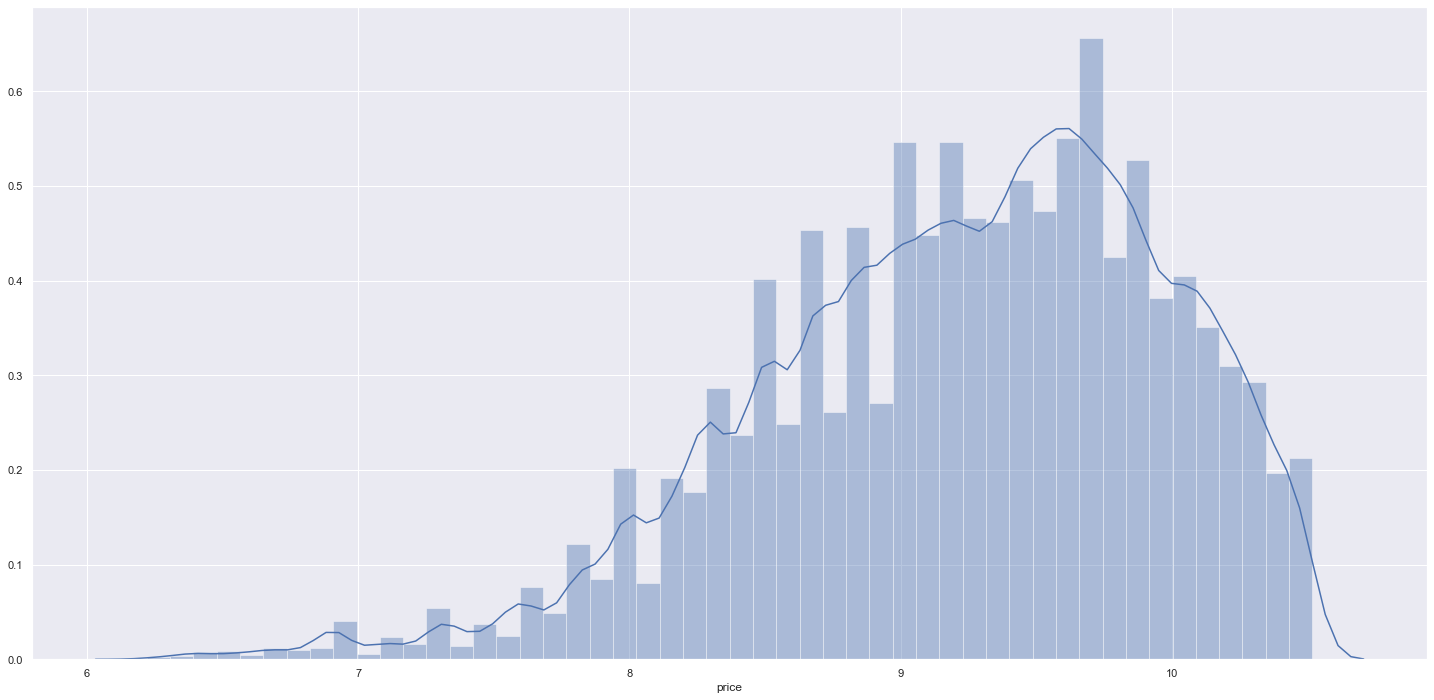

In [89]:
sns.distplot( df5['price'] )

### 5.3.3 Nature Transformation

In [90]:
# There isn't nature variable to transform.

In [91]:
df5.head()

,city,price,year,manufacturer,condition,cylinders,odometer,title_status,type,paint_color,state,lat,long,region,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd
3,219,9.105091,-1.000,7,4,5,-0.555779,6,7,8,3,-0.653562,-0.892995,3,0,0,1,0,0,1,0,0,0,0,1
7,201,9.047939,-0.875,13,4,6,-0.448961,6,1,9,21,0.624310,0.656202,1,0,0,1,0,0,1,0,0,0,0,1
12,201,7.919720,-0.750,7,3,8,0.791578,6,10,10,21,0.503849,0.618967,1,0,0,1,0,0,1,0,0,1,0,0
19,139,10.123867,0.625,39,4,4,-0.810818,6,9,5,26,0.814454,-0.763794,3,0,0,1,0,0,1,0,0,1,0,0
20,257,8.853094,-0.375,10,4,6,0.086316,6,9,0,37,0.797181,-1.182321,3,0,0,1,0,0,1,0,0,0,1,0


# 6.0 STEP 06 - FEATURE SELECTION

In [92]:
df6 = df5.copy()

In [93]:
df6.shape

(232914, 25)

## 6.1 Split dataframe into training and test dataset

In [94]:
# Create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df6, df6['price'], test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(186331, 25) (186331,)
(46583, 25) (46583,)


## 6.2 Boruta as Feature Selection

In [95]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['price'], axis=1 ).values
y_train_n = y_train.values.ravel()

# defines RandomForestRegression
rf = RandomForestRegressor( n_jobs=-1 )

# defines Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	13


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	13


### 6.1.1 Best Feature from Boruta

In [96]:
cols_selected = boruta.support_.tolist()

# best feature
X_train_fs = X_train.drop( ['price'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [97]:
cols_selected_boruta

['city',
 'year',
 'manufacturer',
 'condition',
 'cylinders',
 'odometer',
 'type',
 'lat',
 'long',
 'fuel_diesel',
 'drive_fwd']

In [98]:
cols_not_selected_boruta

['drive_4wd',
 'drive_rwd',
 'fuel_electric',
 'fuel_gas',
 'fuel_hybrid',
 'fuel_other',
 'paint_color',
 'region',
 'state',
 'title_status',
 'transmission_automatic',
 'transmission_manual',
 'transmission_other']

In [99]:
# Let's compare what the Boruta decided with my consideration after the EDA step.
tab = [['Hypoteses', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'True', 'High'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Medium'],
       ['H5', 'True', 'Medium'],
       ['H6', 'True', 'High'],
       ['H7', 'False', 'High'],
       ['H8', 'True', 'High'],
       ['H9', 'True', 'Medium'],
       ['H10', 'False', 'Low'],
       ['H11', 'True', 'High'],
       ['H12', 'False', 'Low'],
       ['H13', 'True', 'High']
      ]
print( tabulate( tab, headers='firstrow' ) )

Hypoteses    Conclusion    Relevance
-----------  ------------  -----------
H1           True          High
H2           True          High
H3           False         Medium
H4           False         Medium
H5           True          Medium
H6           True          High
H7           False         High
H8           True          High
H9           True          Medium
H10          False         Low
H11          True          High
H12          False         Low
H13          True          High


## 6.3 Manual Feature Selection

In [100]:
cols_selected_boruta = ['city',
                        'year',
                        'manufacturer',
                        'condition',
                        'cylinders',
                        'odometer',
                        'type',
                        'lat',
                        'long',
                        'fuel_diesel',
                        'fuel_electric',
                        'fuel_gas',
                        'fuel_hybrid',
                        'fuel_other',
                        'drive_fwd',
                        'drive_4wd',
                        'drive_rwd'
                        ]

# columns to add
feat_to_add = ['price']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [101]:
cols_selected_boruta

['city',
 'year',
 'manufacturer',
 'condition',
 'cylinders',
 'odometer',
 'type',
 'lat',
 'long',
 'fuel_diesel',
 'fuel_electric',
 'fuel_gas',
 'fuel_hybrid',
 'fuel_other',
 'drive_fwd',
 'drive_4wd',
 'drive_rwd']

In [102]:
cols_selected_boruta_full

['city',
 'year',
 'manufacturer',
 'condition',
 'cylinders',
 'odometer',
 'type',
 'lat',
 'long',
 'fuel_diesel',
 'fuel_electric',
 'fuel_gas',
 'fuel_hybrid',
 'fuel_other',
 'drive_fwd',
 'drive_4wd',
 'drive_rwd',
 'price']

# 7.0 STEP 07 - MACHINE LEARNING MODELLING

In [103]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Data Preparartion
X_training = X_train[ cols_selected_boruta_full ]

# Before continuing into sessions that we will implement the Machine Learning models, I would like to explain about the error meanings.
# MAE:
# It is usually what I use to report to the business team because is easier to explain.
# It takes the absolute value of the difference between the real and the predicted number and divides it by the number of predictions, that is, for each value that the model predicts it varies the MAE value on average (both for more and for less).
# Due to the way the MAE is calculated, it is not sensitive to outliers. If I'm on a project where having an outlier-sensitive error is super important I will use to evaluate my model another error.
# MAPE:
# It is also used to facilitate the understanding of the business team about the error of your model. 
# The MAPE simply represents the percentage of the MAE, that is, how much the error that the model has means in percentage of the real value.
# RMSE:
# This is the error most used by data scientists to measure the performance of the model and its value serves as a parameter in the process of trying to decrease the model error within the project.
# This high use of RMSE is due to the fact that it is sensitive to outliers and this helps data scientists to be more rigorous with model errors.
# In cases where detecting the presence of outliers is important within the project I use RMSE instead of MAE.

## 7.1 Average Model

In [104]:
# The "Average Model" is a very basic algorithm to have a base to compare its error with the errors of the other algorithms.

aux1 = x_test.copy()
aux1['price'] = y_test.copy()

# prediction
aux2 = aux1['price'].mean()
aux1['predictions'] = aux2
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,6632.937062,0.806168,8687.888629


## 7.2 Linear Regression

In [105]:
# In the beginning I use the Linear Model to see how linear or non-linear our dataset is.

# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,4257.450899,0.492507,5846.889394


### 7.2.1 Linear Regression Model - Cross Validation

In [106]:
lr_result_cv = cross_validation( X_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,4285.33 +/- 0.0,0.5 +/- 0.0,5890.7 +/- 0.0


## 7.3 Linear Regression Regularized Model

In [107]:
# model
lrr = Lasso( alpha=0.00001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,4257.485827,0.492512,5846.952363


### 7.3.1 Linear Regresion - Lasso - Cross Validation

In [108]:
lrr_result_cv = cross_validation( X_training, 5, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,4285.36 +/- 0.0,0.5 +/- 0.0,5890.77 +/- 0.0


## 7.4 Random Forest Regressor

In [109]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1741.300815,0.207026,2922.005368


### 7.4.1 Random Forest Regressor - Cross Validation

In [110]:
rf_result_cv = cross_validation( X_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

# When we use "Cross Validation" we see that the error drops even more.


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,682.57 +/- 0.0,0.07 +/- 0.0,1225.55 +/- 0.0


## 7.5 XGBoost Regressor

In [111]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,2134.871809,0.226991,3187.910039


### 7.5.1. XGBoost Regressor - Cross Validation

In [112]:
xgb_result_cv = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1980.8 +/- 0.0,0.2 +/- 0.0,2921.79 +/- 0.0


## 7.6 Compare Model's Performance

### 7.6.1. Single Performance

In [113]:
# I will set up a table that shows all the algorithms used and their errors, but without taking in consideration Croos Validation.

modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1741.300815,0.207026,2922.005368
0,XGBoost Regressor,2134.871809,0.226991,3187.910039
0,Linear Regression,4257.450899,0.492507,5846.889394
0,Linear Regression - Lasso,4257.485827,0.492512,5846.952363
0,Average Model,6632.937062,0.806168,8687.888629


### 7.6.2. Real Performance - Cross Validation

In [114]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

# The "Random Forest Regressor" is the best model of all tested here.
# In the first cycle I will take the model and continue the project steps. In the next cycle, if necessary, I test other models and also improve data handling.

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,4285.33 +/- 0.0,0.5 +/- 0.0,5890.7 +/- 0.0
0,Linear Regression - Lasso,4285.36 +/- 0.0,0.5 +/- 0.0,5890.77 +/- 0.0
0,Random Forest Regressor,682.57 +/- 0.0,0.07 +/- 0.0,1225.55 +/- 0.0
0,XGBoost Regressor,1980.8 +/- 0.0,0.2 +/- 0.0,2921.79 +/- 0.0


# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [115]:
# I will use the Random Search method to choose the better Hyperparameter in Random Forest Regressor

param = {
         'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
        }

MAX_EVAL = 3

In [116]:
final_result = pd.DataFrame()

import random

for i in range( MAX_EVAL):
    #chose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    rf = RandomForestRegressor( bootstrap = hp['bootstrap'],
                                max_depth = hp['max_depth'],
                                max_features = hp['max_features'],
                                min_samples_leaf = hp['min_samples_leaf'],
                                min_samples_split = hp['min_samples_split'],
                                n_estimators = hp['n_estimators'] )

    # performance
    result = cross_validation( X_training, 5, 'Random Forest Regressor', rf, verbose=False)
    final_result = pd.concat( [final_result, result] )

final_result

{'bootstrap': True, 'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1800}
{'bootstrap': True, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}
{'bootstrap': False, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1000}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,864.79 +/- 0.16,0.09 +/- 0.0,1556.17 +/- 0.27
0,Random Forest Regressor,1499.85 +/- 0.89,0.16 +/- 0.0,2361.94 +/- 1.4
0,Random Forest Regressor,1220.62 +/- 0.0,0.13 +/- 0.0,2059.91 +/- 0.0


## 8.2 Final Model

In [117]:
# The first one above was the best parameter.
param_tuned = {
         'bootstrap': True,
         'max_depth': 70,
         'max_features': 'auto',
         'min_samples_leaf': 2,
         'min_samples_split': 2,
         'n_estimators': 1800
        }

In [ ]:
# model
rf_tuned = RandomForestRegressor( bootstrap = param_tuned['bootstrap'],
                                  max_depth = param_tuned['max_depth'],
                                  max_features = param_tuned['max_features'],
                                  min_samples_leaf = param_tuned['min_samples_leaf'],
                                  min_samples_split = param_tuned['min_samples_split'],
                                  n_estimators = param_tuned['n_estimators'] ).fit( x_train, y_train )

# prediction
yhat_rf_tuned = rf_tuned.predict( x_test )

# performance
rf_result_tuned = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf_tuned ) )
rf_result_tuned

In [ ]:
# As the MPE value is negative, we found that the model in general is overestimating the forecast, that is, it is forecasting more values above the real.
# In any case, the value of the MPE is very small and does not have much influence on our model.

mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_rf_tuned ) )
mpe